# Inputs, Libraries, Params

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal # For synthesis filters

# Parameters for inputs 
N = 1024  # Size of the vector
N_FFT = 1024  # FFT points for frequency response
min = -2**15       # -32768
max = 2**15 - 1    #  32767
n = np.arange(N) # [0 1  ... 1023]

plt.rcParams["figure.figsize"] = (8, 4) # Sets default size for all figures

#### Input Type I 
Random Data (Complex random variable, 16-bit real and imaginary parts) (All Pass White Noise)


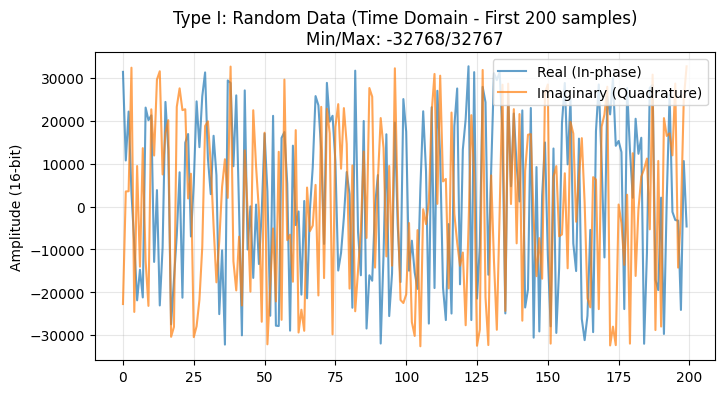

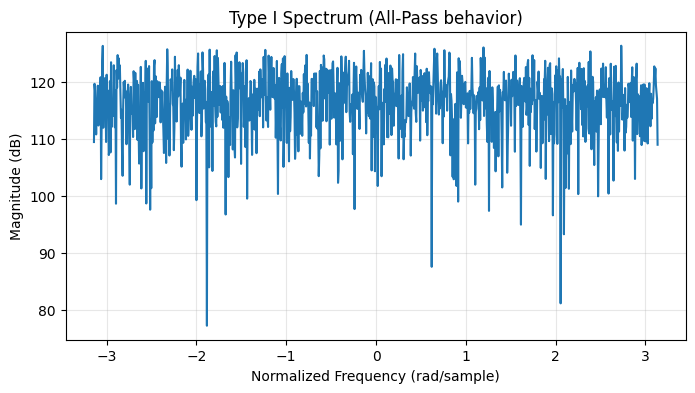

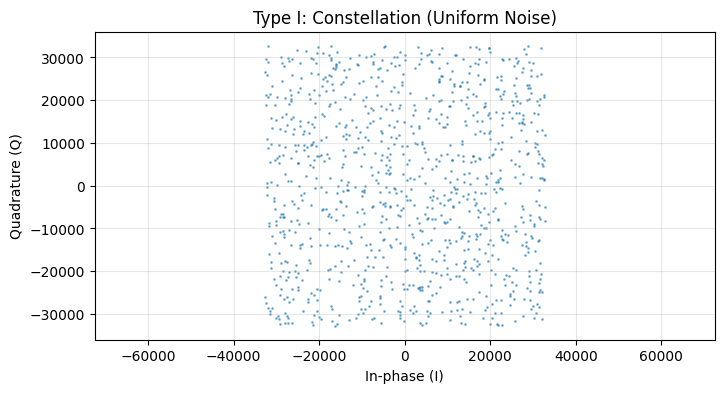

In [47]:
sgn_real_rand = np.random.randint(min, max + 1, N) # [-17518 -21082 -12534 ... -29234 -15016 -14005]
sgn_img_rand = np.random.randint(min, max + 1, N) # [-2 -1  1 ...  9 -3  9]
sgn_rand = sgn_real_rand + 1j * sgn_img_rand # [-17518-2j -21082-1j -12534+1j ... -29234+9j -15016-3j -14005+9j

plt.plot(n[:200], np.real(sgn_rand)[:200], label='Real (In-phase)', alpha=0.7)
plt.plot(n[:200], np.imag(sgn_rand)[:200], label='Imaginary (Quadrature)', alpha=0.7)
plt.title(f'Type I: Random Data (Time Domain - First 200 samples)\nMin/Max: {min}/{max}')
plt.ylabel('Amplitude (16-bit)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

fft_sgn_rand = np.fft.fft(sgn_rand) # Compute FFT
fft_sgn_rand = np.fft.fftshift(fft_sgn_rand) # Shift zero freq to center
freqs = np.fft.fftshift(np.fft.fftfreq(N)) * 2 * np.pi # Normalized freq -pi to pi
plt.plot(freqs, 20 * np.log10(np.abs(fft_sgn_rand) + 1e-9)) # Magnitude in dB (1e-9 to avoid log(0))
plt.title('Type I Spectrum (All-Pass behavior)')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Normalized Frequency (rad/sample)')
plt.grid(True, alpha=0.3)
plt.show()

plt.scatter(np.real(sgn_rand), np.imag(sgn_rand), s=1, alpha=0.5)
plt.title('Type I: Constellation (Uniform Noise)')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

#### Input Type II
Band Pass Signal

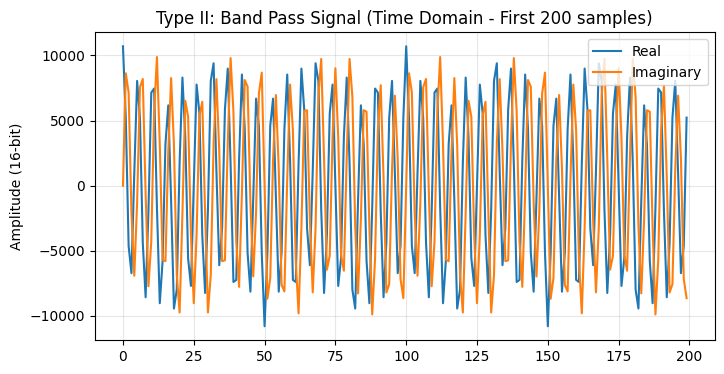

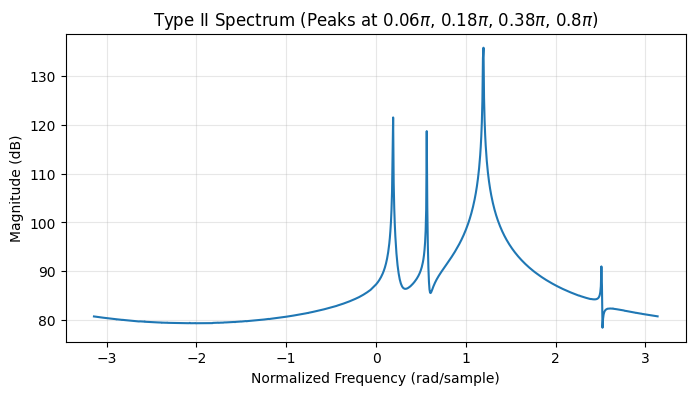

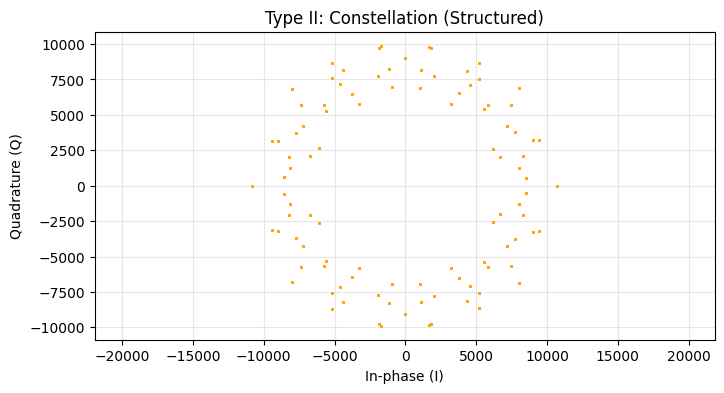

In [48]:
sgn_bp_real = (1344 * np.cos(0.06 * np.pi * n) + 
         864  * np.cos(0.18 * np.pi * n) + 
         8543 * np.cos(0.38 * np.pi * n) - 
         43   * np.cos(0.8  * np.pi * n)) # [10708.          5229.36917696 -4623.37380987 ...  8306.62220311 3761.18064657 -5574.36248218]
sgn_bp_img = (1344 * np.sin(0.06 * np.pi * n) + 
         864  * np.sin(0.18 * np.pi * n) + 
         8543 * np.sin(0.38 * np.pi * n) - 
         43   * np.sin(0.8  * np.pi * n)) # [    0.          8632.36917696  7165.62619013 ... -2092.62220311  6527.81935343  5304.36248218]

# Enforce 16-bit integer constraint (rounding and casting)
sgn_bp_real = np.clip(sgn_bp_real, min, max).astype(np.int16) # [10708  5229 -4623 ...  8306  3761 -5574]
sgn_bp_img = np.clip(sgn_bp_img, min, max).astype(np.int16) # [    0  8632  7165 ... -2092  6527  5304]
sgn_bp = sgn_bp_real + 1j * sgn_bp_img

plt.plot(n[:200], np.real(sgn_bp)[:200], label='Real') # Zoomed in for visibility
plt.plot(n[:200], np.imag(sgn_bp)[:200], label='Imaginary')
plt.title('Type II: Band Pass Signal (Time Domain - First 200 samples)')
plt.ylabel('Amplitude (16-bit)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

fft_sgn_bp = np.fft.fft(sgn_bp) # Compute FFT
fft_sgn_bp = np.fft.fftshift(fft_sgn_bp) # Shift zero freq to center
freqs = np.fft.fftshift(np.fft.fftfreq(N)) * 2 * np.pi # Normalized freq -pi to pi
plt.plot(freqs, 20 * np.log10(np.abs(fft_sgn_bp) + 1e-9)) # Magnitude in dB (1e-9 to avoid log(0))
plt.title('Type II Spectrum (Peaks at 0.06$\pi$, 0.18$\pi$, 0.38$\pi$, 0.8$\pi$)')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Normalized Frequency (rad/sample)')
plt.grid(True, alpha=0.3)
plt.show()

plt.scatter(np.real(sgn_bp), np.imag(sgn_bp), s=1, color='orange', alpha=0.5)
plt.title('Type II: Constellation (Structured)')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

# PART-I Polyphase Filters

#### HPF and LPF Filters

Calculated LPF DC Gain (Linear) - 2050.0, Actual - 2050.0


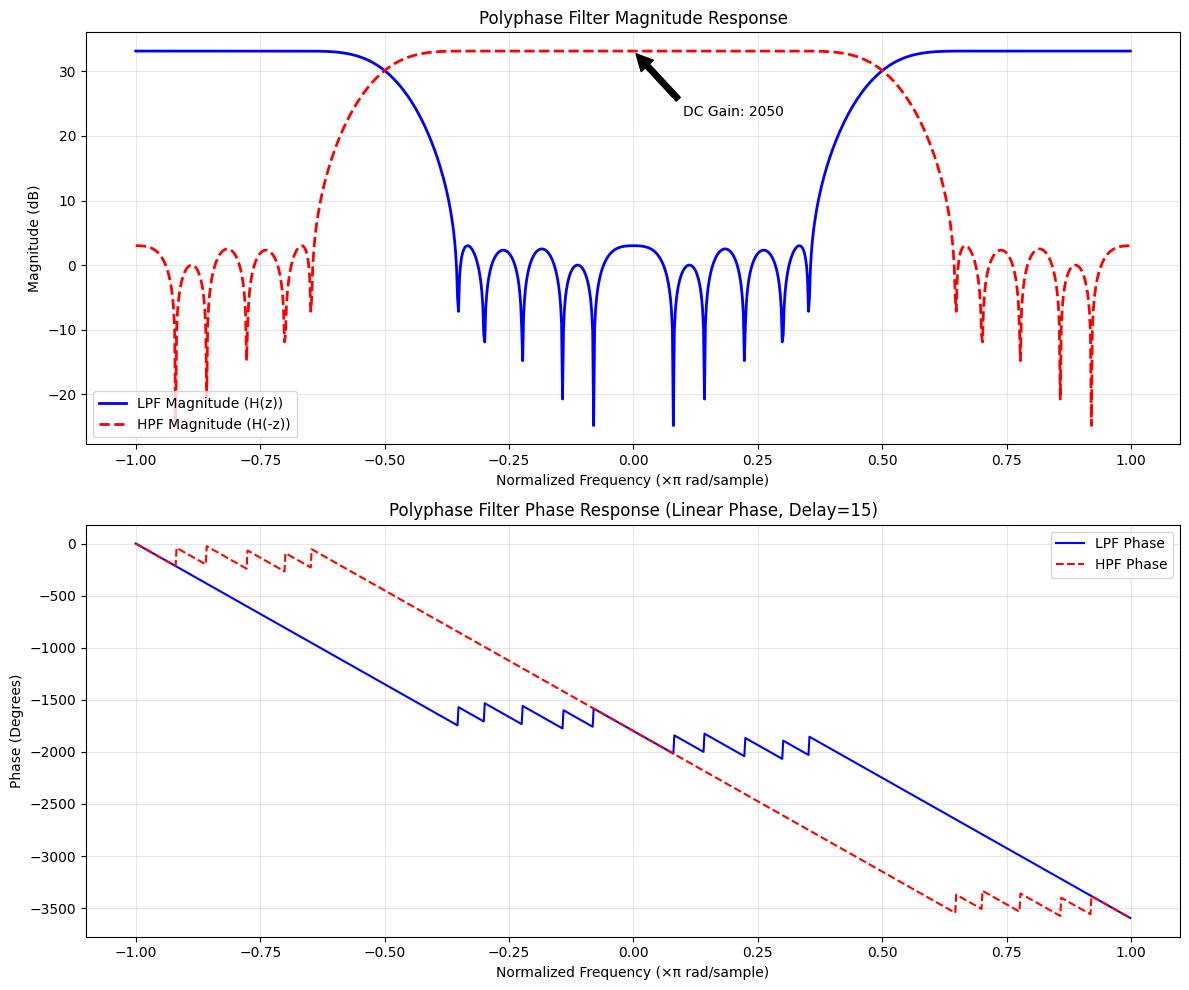

In [49]:
# Define the Coefficients (N=31): H(n) = [-1, 0, 3, 0, -8, 0, 21, 0, -45, 0, 91, 0, -191, 0, 643, 1024, 643, ...]
h_lpf = np.array([
    -1, 0, 3, 0, -8, 0, 21, 0, -45, 0, 91, 0, -191, 0, 643, 
    1024, 
    643, 0, -191, 0, 91, 0, -45, 0, 21, 0, -8, 0, 3, 0, -1
], dtype=float)

# High Pass Filter (HPF) coefficients: H_hpf(z) = H_lpf(-z)
n = np.arange(len(h_lpf))
h_hpf = h_lpf * ((-1)**n) #h_hpf[n] = h_lpf[n] * (-1)^n

# Calculate Frequency Response
w, h_lpf_freq = signal.freqz(h_lpf, worN=N_FFT, whole=True)
_, h_hpf_freq = signal.freqz(h_hpf, worN=N_FFT, whole=True)

# freqs has to 0 to 2pi for plotting
freqs = w / np.pi  # Normalized frequency (0 to 2)
center_freqs = freqs - 1  # Centered frequency (-1 to 1)

# Calculate Gain to verify text (Gain = 2050)
gain_lpf_linear = np.abs(np.sum(h_lpf))
print(f"Calculated LPF DC Gain (Linear) - {gain_lpf_linear}, Actual - {h_lpf_freq[0].real}")

# Convert response to dB
mag_lpf_db = 10 * np.log10(np.abs(h_lpf_freq) + 1e-12)
mag_hpf_db = 10 * np.log10(np.abs(h_hpf_freq) + 1e-12)

# Calculate Phase in Degrees
phase_lpf = np.unwrap(np.angle(h_lpf_freq)) * 180 / np.pi
phase_hpf = np.unwrap(np.angle(h_hpf_freq)) * 180 / np.pi

# Plotting
plt.figure(figsize=(12, 10))

# Magnitude Plot
plt.subplot(2, 1, 1)
plt.plot(center_freqs, mag_lpf_db, label='LPF Magnitude (H(z))', color='blue', linewidth=2)
plt.plot(center_freqs, mag_hpf_db, label='HPF Magnitude (H(-z))', color='red', linestyle='--', linewidth=2)
plt.title('Polyphase Filter Magnitude Response')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.grid(True, alpha=0.3)
plt.legend()
# plt.xlim(0, 1)

# Add Annotation for Gain
plt.annotate(f'DC Gain: {gain_lpf_linear:.0f}', xy=(0, mag_lpf_db[0]), 
             xytext=(0.1, mag_lpf_db[0]-10),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Phase Plot
plt.subplot(2, 1, 2)
plt.plot(center_freqs, phase_lpf, label='LPF Phase', color='blue')
plt.plot(center_freqs, phase_hpf, label='HPF Phase', color='red', linestyle='--')
plt.title(f'Polyphase Filter Phase Response (Linear Phase, Delay={len(h_lpf)//2})')
plt.ylabel('Phase (Degrees)')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.grid(True, alpha=0.3)
plt.legend()
# plt.xlim(0, 1)

plt.tight_layout()
plt.show()

#### Analysis Filters

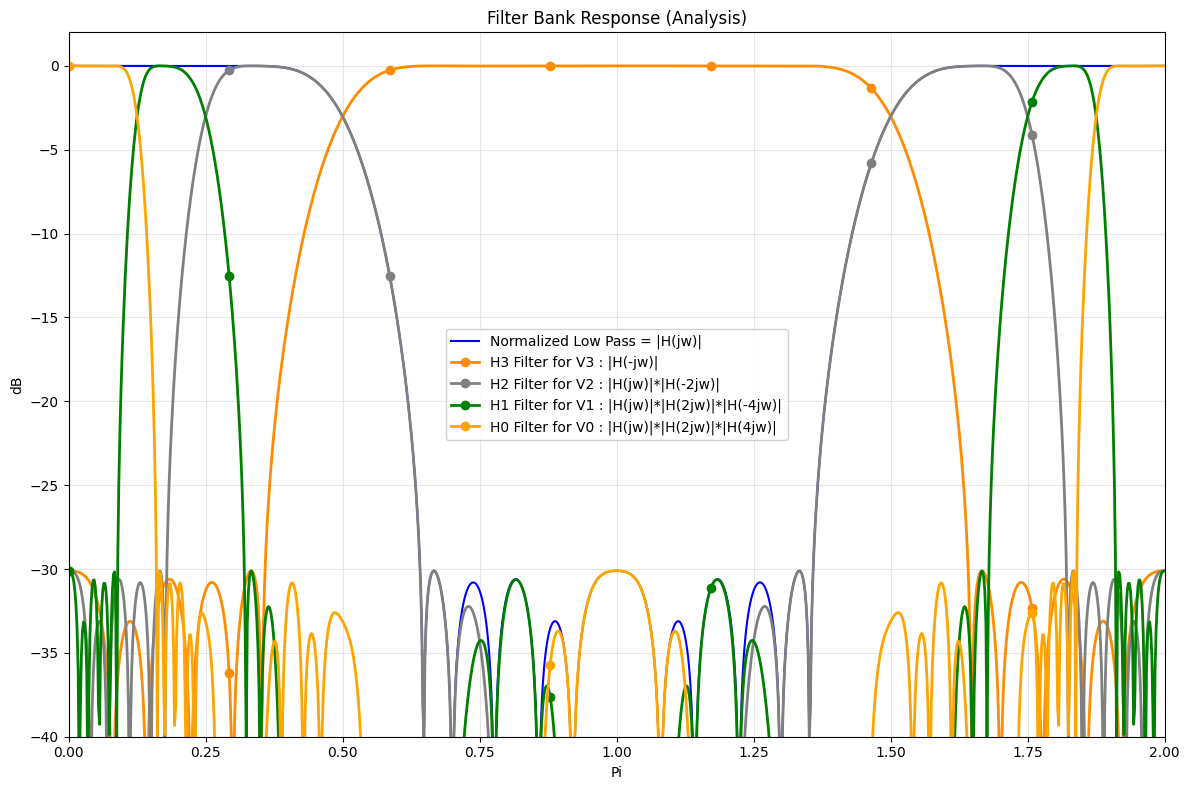

In [50]:
w, H_z = signal.freqz(h_lpf, worN=N_FFT, whole=True)
_, H_minus_z = signal.freqz(h_hpf, worN=N_FFT, whole=True)

# Normalize frequency axis (0 to 2pi)
freqs = w / np.pi

# Compute Cascaded Responses (Noble Identities)
def upsample_filter(h, factor):
    h_up = np.zeros((len(h) * factor) - (factor - 1)) # Length after upsampling = len(h)*factor - (factor-1)
    h_up[::factor] = h # Insert zeros between coefficients at intervals of 'factor'
    return h_up

# Create upsampled versions of filters for equivalent cascade calculation
h_lpf_2 = upsample_filter(h_lpf, 2)   # H(z^2)
h_hpf_2 = upsample_filter(h_hpf, 2)   # H(-z^2)
h_lpf_4 = upsample_filter(h_lpf, 4)   # H(z^4)
h_hpf_4 = upsample_filter(h_hpf, 4)   # H(-z^4)

# Compute Frequency Responses of these upsampled components
_, H_z_2 = signal.freqz(h_lpf_2, worN=N_FFT, whole=True)
_, H_mz_2 = signal.freqz(h_hpf_2, worN=N_FFT, whole=True)
_, H_z_4 = signal.freqz(h_lpf_4, worN=N_FFT, whole=True)
_, H_mz_4 = signal.freqz(h_hpf_4, worN=N_FFT, whole=True)

# Calculate Final Channel Responses (V0 - V3)
GAIN = 2050

H_V3_resp = np.abs(H_minus_z) # V3: Path -> H(-z)
H_V2_resp = np.abs(H_z) * np.abs(H_mz_2) # V2: Path -> H(z) * H(-z^2)
H_V1_resp = np.abs(H_z) * np.abs(H_z_2) * np.abs(H_mz_4) # V1: Path -> H(z) * H(z^2) * H(-z^4)
H_V0_resp = np.abs(H_z) * np.abs(H_z_2) * np.abs(H_z_4) # V0: Path -> H(z) * H(z^2) * H(z^4)

# NORMALIZATION & SCALING
H_V0_db = 10 * np.log10(H_V0_resp / np.max(H_V0_resp))
H_V1_db = 10 * np.log10(H_V1_resp / np.max(H_V1_resp))
H_V2_db = 10 * np.log10(H_V2_resp / np.max(H_V2_resp))
H_V3_db = 10 * np.log10(H_V3_resp / np.max(H_V3_resp))

# For the envelope (Blue line), we keep it relative to the main Gain
# We also use 10*log10 here to be consistent with the other curves
Base_LP_db = 10 * np.log10(np.abs(H_z)/GAIN)

# --- 5. Plotting ---
plt.figure(figsize=(12, 8))

# Limit Y-axis to relevant range (e.g., -40dB to 5dB)
plt.ylim(-40, 2)

# Plot curves matching Figure 3 colors/style/Legend Text
plt.plot(freqs, Base_LP_db, label='Normalized Low Pass = |H(jw)|', color='blue', linewidth=1.5)
plt.plot(freqs, H_V3_db, label='H3 Filter for V3 : |H(-jw)|', color='darkorange', linewidth=2, marker='o', markevery=150)
plt.plot(freqs, H_V2_db, label='H2 Filter for V2 : |H(jw)|*|H(-2jw)|', color='gray', linewidth=2, marker='o', markevery=150)
plt.plot(freqs, H_V1_db, label='H1 Filter for V1 : |H(jw)|*|H(2jw)|*|H(-4jw)|', color='green', linewidth=2, marker='o', markevery=150)
plt.plot(freqs, H_V0_db, label='H0 Filter for V0 : |H(jw)|*|H(2jw)|*|H(4jw)|', color='orange', linewidth=2, marker='o', markevery=150)

plt.title('Filter Bank Response (Analysis)')
plt.ylabel('dB')
plt.xlabel('Pi')
plt.grid(True, alpha=0.3)
plt.legend(framealpha=0.9, loc='center')
plt.xlim(0, 2)

plt.tight_layout()
plt.show()

#### Synthesis Filter

Note: The following code plots T(z) and A(z) for a 2 channel filter banks (QMF), This is not needed for the project but done to explore

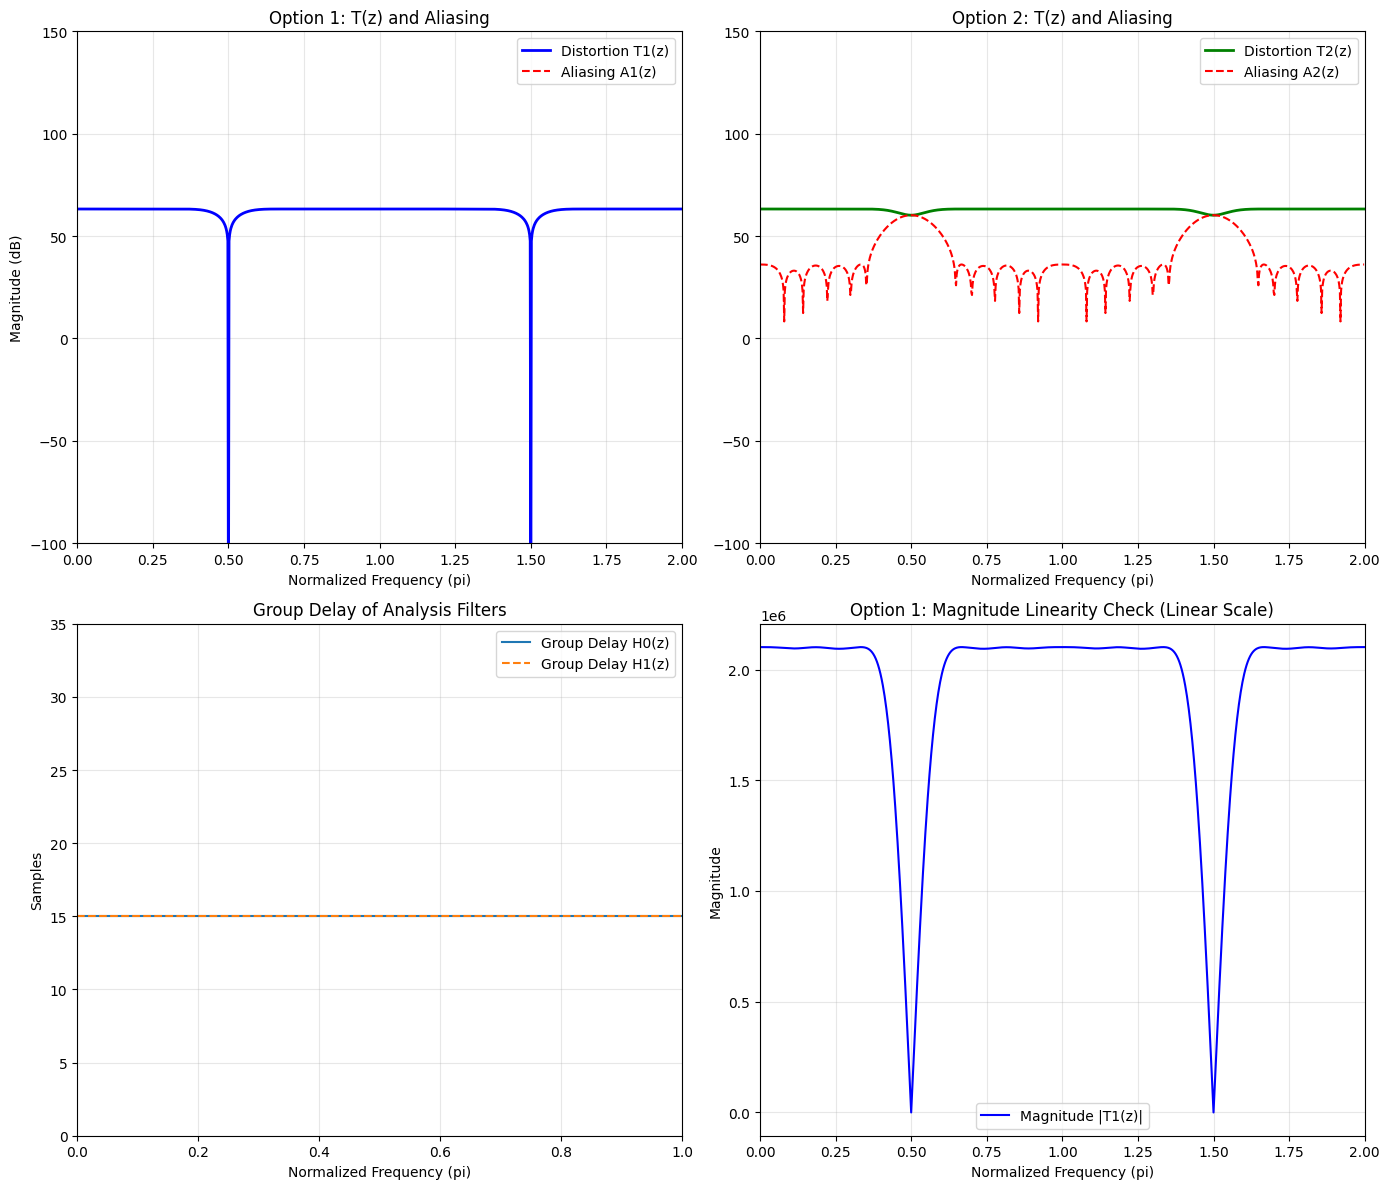

--- Option 1 Analysis ---
Max Aliasing Magnitude (dB): -102.35

--- Option 2 Analysis ---
Max Aliasing Magnitude (dB): 60.21


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# --- 1. Define Analysis Filters H0(z) and H1(z) ---
# H0 = Low Pass (given in previous steps)
h0 = np.array([
    -1, 0, 3, 0, -8, 0, 21, 0, -45, 0, 91, 0, -191, 0, 643, 
    1024, 
    643, 0, -191, 0, 91, 0, -45, 0, 21, 0, -8, 0, 3, 0, -1
], dtype=float)

# H1 = High Pass = H0(-z) => h1[n] = h0[n] * (-1)^n
n = np.arange(len(h0))
h1 = h0 * ((-1)**n)

# --- 2. Define Synthesis Filters F0(z) and F1(z) ---

# Option 1: F0 = H0, F1 = -H1
f0_opt1 = h0.copy()
f1_opt1 = -h1.copy()

# Option 2: F0 = H0, F1 = H1
f0_opt2 = h0.copy()
f1_opt2 = h1.copy()

def analyze_system(h0, h1, f0, f1, name):
    w, H0 = signal.freqz(h0, worN=N_FFT, whole=True)
    _, H1 = signal.freqz(h1, worN=N_FFT, whole=True)
    _, F0 = signal.freqz(f0, worN=N_FFT, whole=True)
    _, F1 = signal.freqz(f1, worN=N_FFT, whole=True)
    
    mid = N_FFT // 2
    H0_minus_z = np.roll(H0, mid)
    H1_minus_z = np.roll(H1, mid)
    
    # Calculate Distortion Function T(z)
    # T(z) = 0.5 * [H0(z)F0(z) + H1(z)F1(z)]
    T_z = 0.5 * (H0 * F0 + H1 * F1)
    
    # Calculate Aliasing Function A(z)
    # A(z) = 0.5 * [H0(-z)F0(z) + H1(-z)F1(z)]
    A_z = 0.5 * (H0_minus_z * F0 + H1_minus_z * F1)
    
    return w, T_z, A_z

# Run Analysis
w, T1, A1 = analyze_system(h0, h1, f0_opt1, f1_opt1, "Option 1")
_, T2, A2 = analyze_system(h0, h1, f0_opt2, f1_opt2, "Option 2")

# Normalize frequency for plotting
freqs = w / np.pi

# Group Delay Calculation
def calc_group_delay(h):
    w_gd, gd = signal.group_delay((h, 1), w=N_FFT)
    return w_gd / np.pi, gd

w_gd, gd_h0 = calc_group_delay(h0)
_, gd_h1 = calc_group_delay(h1)

# PLOTTING
plt.figure(figsize=(14, 12))

# Plot 1: Option 1 (T1 and A1)
plt.subplot(2, 2, 1)
plt.plot(freqs, 10 * np.log10(np.abs(T1)+1e-15), label='Distortion T1(z)', color='blue', linewidth=2)
plt.plot(freqs, 10 * np.log10(np.abs(A1)+1e-15), label='Aliasing A1(z)', color='red', linestyle='--')
plt.title('Option 1: T(z) and Aliasing')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Normalized Frequency (pi)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-100, 150) 
plt.xlim(0, 2)

# Plot 2: Option 2 (T2 and A2)
plt.subplot(2, 2, 2)
plt.plot(freqs, 10 * np.log10(np.abs(T2)+1e-15), label='Distortion T2(z)', color='green', linewidth=2)
plt.plot(freqs, 10 * np.log10(np.abs(A2)+1e-15), label='Aliasing A2(z)', color='red', linestyle='--')
plt.title('Option 2: T(z) and Aliasing')
plt.xlabel('Normalized Frequency (pi)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-100, 150)
plt.xlim(0, 2)

# Plot 3: Group Delay of Filters
plt.subplot(2, 2, 3)
plt.plot(w_gd, gd_h0, label='Group Delay H0(z)')
plt.plot(w_gd, gd_h1, label='Group Delay H1(z)', linestyle='--')
plt.title('Group Delay of Analysis Filters')
plt.ylabel('Samples')
plt.xlabel('Normalized Frequency (pi)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 35)
plt.xlim(0, 1)

# Plot 4: Option 1 T(z) to check flatness (PR)
plt.subplot(2, 2, 4)
plt.plot(freqs, np.abs(T1), label='Magnitude |T1(z)|', color='blue')
plt.title('Option 1: Magnitude Linearity Check (Linear Scale)')
plt.ylabel('Magnitude')
plt.xlabel('Normalized Frequency (pi)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 2)

plt.tight_layout()
plt.show()

print(f"--- Option 1 Analysis ---")
print(f"Max Aliasing Magnitude (dB): {10*np.log10(np.max(np.abs(A1))):.2f}")

print(f"\n--- Option 2 Analysis ---")
print(f"Max Aliasing Magnitude (dB): {10*np.log10(np.max(np.abs(A2))):.2f}")


Plot the synthesis filter response

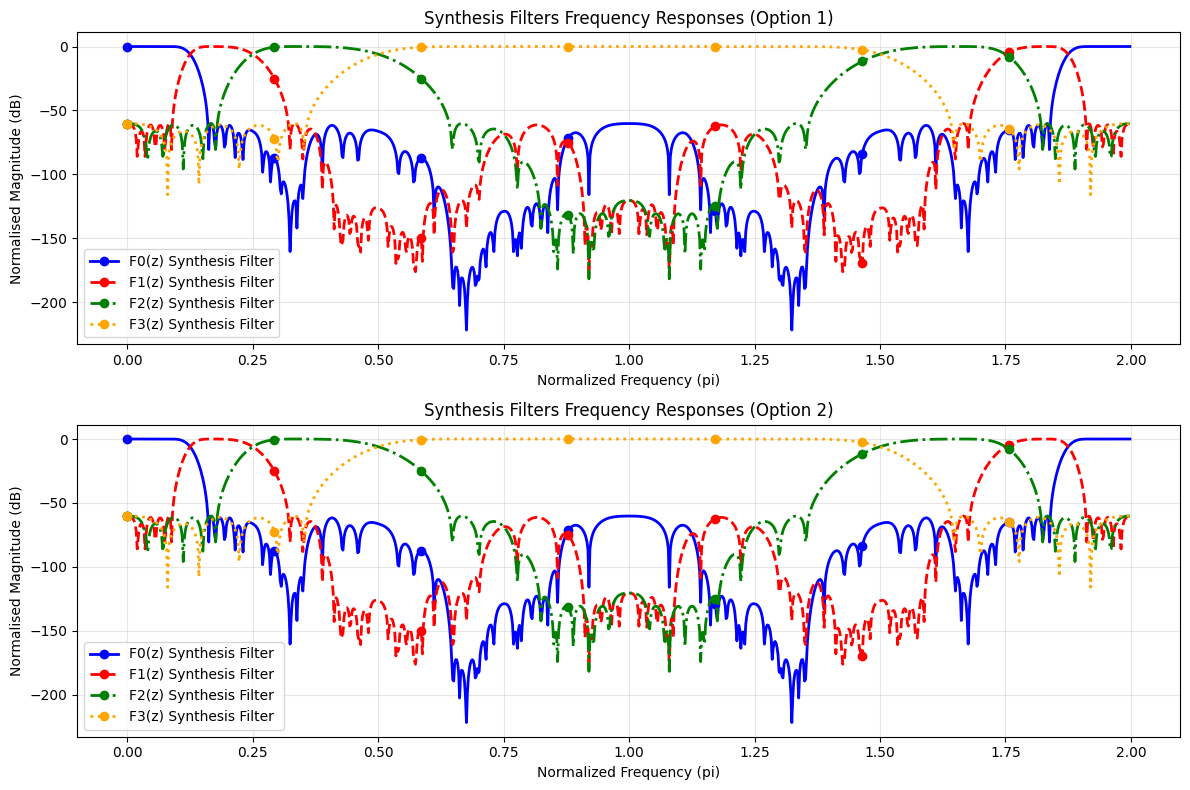

In [52]:
def get_upsampled_filter(h, factor):
    h_up = np.zeros((len(h) * factor) - (factor - 1)) # Length after upsampling = len(h)*factor - (factor-1)
    h_up[::factor] = h
    return h_up

def get_synthesis_filter(f_low_coeffs, f_high_coeffs, label):
    F_z   = f_low_coeffs
    F_mz  = f_high_coeffs
    
    F_z2  = get_upsampled_filter(f_low_coeffs, 2)
    F_mz2 = get_upsampled_filter(f_high_coeffs, 2)    
    F_z4  = get_upsampled_filter(f_low_coeffs, 4)
    F_mz4 = get_upsampled_filter(f_high_coeffs, 4)

    Feq_V0 = signal.convolve(signal.convolve(F_z4, F_z2), F_z) # Path V0 (Rate 8): H(z)H(z2)H(z4) -> F(z4)F(z2)F(z)
    Feq_V1 = signal.convolve(signal.convolve(F_mz4, F_z2), F_z) # Path V1 (Rate 8): H(z)H(z2)H(-z4) -> F(-z4)F(z2)F(z)
    Feq_V2 = signal.convolve(F_mz2, F_z) # Path V2 (Rate 4): H(z)H(-z2) -> F(-z2)F(z)
    Feq_V3 = F_mz # Path V3 (Rate 2): H(-z) -> F(-z)

    _, F_V0_resp = signal.freqz(Feq_V0, worN=N_FFT, whole=True)
    _, F_V1_resp = signal.freqz(Feq_V1, worN=N_FFT, whole=True)
    _, F_V2_resp = signal.freqz(Feq_V2, worN=N_FFT, whole=True)
    _, F_V3_resp = signal.freqz(Feq_V3, worN=N_FFT, whole=True)

    return w, F_V0_resp, F_V1_resp, F_V2_resp, F_V3_resp

# Generate synthesis filters for Both Options
# Option 1: F0=H0, F1=-H1
f_low_opt1 = h_lpf
f_high_opt1 = -h_hpf
w, F_V0_resp1, F_V1_resp1, F_V2_resp1, F_V3_resp1 = get_synthesis_filter(f_low_opt1, f_high_opt1, "Option 1")

F_V0_resp1_norm = F_V0_resp1 / np.max(np.abs(F_V0_resp1))
F_V1_resp1_norm = F_V1_resp1 / np.max(np.abs(F_V1_resp1))
F_V2_resp1_norm = F_V2_resp1 / np.max(np.abs(F_V2_resp1))
F_V3_resp1_norm = F_V3_resp1 / np.max(np.abs(F_V3_resp1))

# Option 2: F0=H0, F1=H1
f_low_opt2 = h_lpf
f_high_opt2 = h_hpf
_, F_V0_resp2, F_V1_resp2, F_V2_resp2, F_V3_resp2 = get_synthesis_filter(f_low_opt2, f_high_opt2, "Option 2")

F_V0_resp2_norm = F_V0_resp2 / np.max(np.abs(F_V0_resp2))
F_V1_resp2_norm = F_V1_resp2 / np.max(np.abs(F_V1_resp2))
F_V2_resp2_norm = F_V2_resp2 / np.max(np.abs(F_V2_resp2))
F_V3_resp2_norm = F_V3_resp2 / np.max(np.abs(F_V3_resp2))

freqs = w / np.pi

# SYnthesis Filters Frequency Responses
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(freqs, 20 * np.log10(np.abs(F_V0_resp1_norm)), label='F0(z) Synthesis Filter', color='blue', linewidth=2, marker='o', markevery=150)
plt.plot(freqs, 20 * np.log10(np.abs(F_V1_resp1_norm)), label='F1(z) Synthesis Filter', color='red', linestyle='--', linewidth=2, marker='o', markevery=150)
plt.plot(freqs, 20 * np.log10(np.abs(F_V2_resp1_norm)), label='F2(z) Synthesis Filter', color='green', linestyle='-.', linewidth=2, marker='o', markevery=150)
plt.plot(freqs, 20 * np.log10(np.abs(F_V3_resp1_norm)), label='F3(z) Synthesis Filter', color='orange', linestyle=':', linewidth=2, marker='o', markevery=150)
plt.legend()    
plt.title('Synthesis Filters Frequency Responses (Option 1)')
plt.ylabel('Normalised Magnitude (dB)')
plt.xlabel('Normalized Frequency (pi)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(freqs, 20 * np.log10(np.abs(F_V0_resp2_norm)), label='F0(z) Synthesis Filter', color='blue', linewidth=2, marker='o', markevery=150)
plt.plot(freqs, 20 * np.log10(np.abs(F_V1_resp2_norm)), label='F1(z) Synthesis Filter ', color='red', linestyle='--', linewidth=2, marker='o', markevery=150)
plt.plot(freqs, 20 * np.log10(np.abs(F_V2_resp2_norm)), label='F2(z) Synthesis Filter', color='green', linestyle='-.', linewidth=2, marker='o', markevery=150)
plt.plot(freqs, 20 * np.log10(np.abs(F_V3_resp2_norm)), label='F3(z) Synthesis Filter', color='orange', linestyle=':', linewidth=2, marker='o', markevery=150)
plt.legend()    
plt.title('Synthesis Filters Frequency Responses (Option 2)')
plt.ylabel('Normalised Magnitude (dB)')
plt.xlabel('Normalized Frequency (pi)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### T(z) and A(z) Calculation

Starting Plot Generation...
Calculating Response for Option 1: F1 = -H1...
Alias l=1: Max Magnitude (dB): 186.63
Alias l=2: Max Magnitude (dB): 183.63
Alias l=3: Max Magnitude (dB): 152.88
Alias l=4: Max Magnitude (dB): 159.57
Alias l=5: Max Magnitude (dB): 152.88
Alias l=6: Max Magnitude (dB): 183.63
Alias l=7: Max Magnitude (dB): 186.63
Max Aliasing (dB): 186.63
Average Aliasing (dB): 178.19


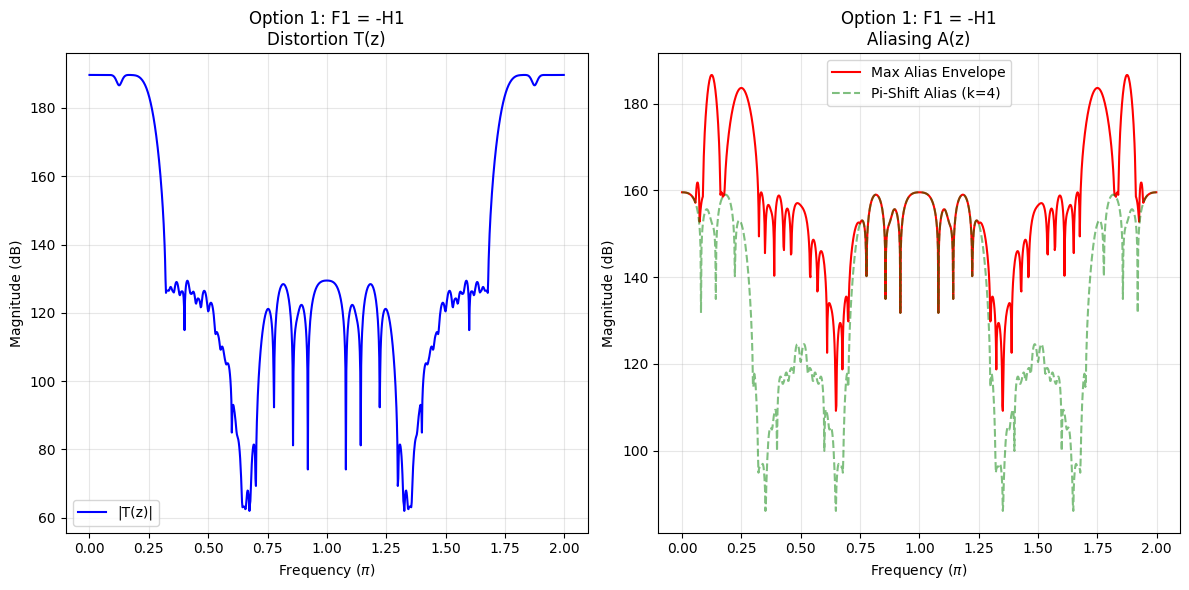

Calculating Response for Option 2: F1 = H1...
Alias l=1: Max Magnitude (dB): 162.51
Alias l=2: Max Magnitude (dB): 183.63
Alias l=3: Max Magnitude (dB): 130.81
Alias l=4: Max Magnitude (dB): 159.57
Alias l=5: Max Magnitude (dB): 130.81
Alias l=6: Max Magnitude (dB): 183.63
Alias l=7: Max Magnitude (dB): 162.51
Max Aliasing (dB): 183.63
Average Aliasing (dB): 175.20


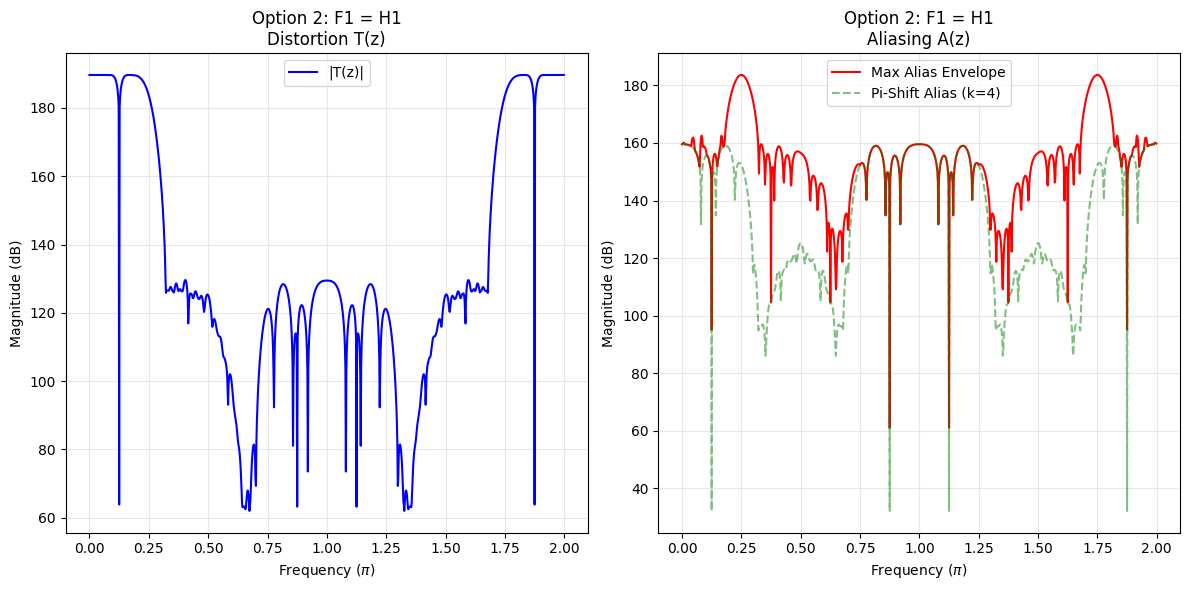

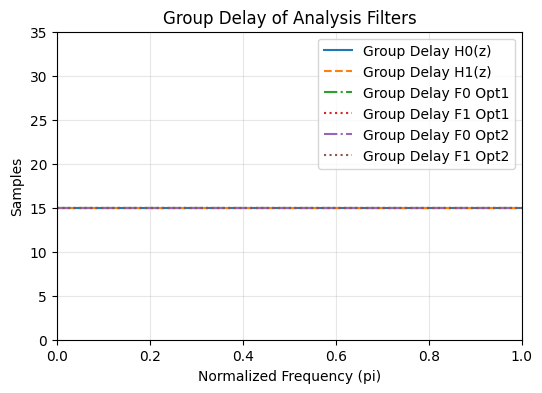

In [53]:
def plot_full_response(option_num, title):
    print(f"Calculating Response for {title}...")
    feqs = []
    if option_num == 1: # Option 1 F0=-H1
        feqs = [F_V0_resp1, F_V1_resp1, F_V2_resp1, F_V3_resp1]
        heqs = [H_V0_resp, H_V1_resp, H_V2_resp, H_V3_resp]
    else: # Option 2 F1=H1
        feqs = [F_V0_resp2, F_V1_resp2, F_V2_resp2, F_V3_resp2]
        heqs = [H_V0_resp, H_V1_resp, H_V2_resp, H_V3_resp]
    
    # List of branches: (AnalysisFilter, Rate, SynthesisFilter)
    branches = [
        (heqs[0], 8, feqs[0]),
        (heqs[1], 8, feqs[1]),
        (heqs[2], 4, feqs[2]),
        (heqs[3], 2, feqs[3])
    ]
    
    w = np.linspace(0, 2*np.pi, N_FFT, endpoint=False)
    
    T_total = np.zeros(N_FFT, dtype=complex)
    alias_accumulator = np.zeros((7, N_FFT)) # Store max alias magnitude across all 7 possible shifts; k=1 corresponds to shift 1*(2pi/8), k=4 is pi shift, etc.

    # T(z) (No shift)
    for (H, rate, F) in branches: # l=0
        T_total += (1/rate) * H * F

    # General Aliasing A_k(z)
    for l in range(1, 8): # l=1 to 7
        Ak = np.zeros(N_FFT, dtype=complex)
        for (H, rate, F) in branches:
            # Branch contributes if (k/8) is a multiple of (1/Rate)
            if (l * rate) % 8 == 0:
                shift_idx = (l * N_FFT) // 8 # Calculate shift index. // operation for integer division
                H_shifted = np.roll(H, shift_idx) # H_shifted = H(z * W^k) => Shift but Roll last index to first for H by k*(2pi/8)                
                Ak += (1/rate) * H_shifted * F
        
        alias_accumulator[l-1] = np.abs(Ak) # l=1 stored at index 0 till l=7 at index 6
        print(f"Alias l={l}: Max Magnitude (dB): {10*np.log10(np.max(np.abs(Ak))):.2f}")
        
    max_alias = np.max(alias_accumulator, axis=0) # Max Envelope of all aliasing terms
    print(f"Max Aliasing (dB): {10*np.log10(np.max(np.abs(max_alias))):.2f}")
    average_alias = np.mean(alias_accumulator, axis=0)
    print(f"Average Aliasing (dB): {10*np.log10(np.max(np.abs(average_alias))):.2f}")
    # Specific Pi-shift alias (k=4) 
    pi_alias_4 = alias_accumulator[3]  # k=4 corresponds to index 3
    # Plotting
    freqs = w / np.pi
    plt.figure(figsize=(12, 6))
    
    # Distortion Plot
    plt.subplot(1, 2, 1)
    plt.plot(freqs, 10*np.log10(np.abs(T_total) + 1e-15), 'b', label='|T(z)|')
    plt.title(f"{title}\nDistortion T(z)")
    plt.xlabel("Frequency ($\pi$)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Aliasing Plot
    plt.subplot(1, 2, 2)
    plt.plot(freqs, 10*np.log10(max_alias), 'r', label='Max Alias Envelope')
    plt.plot(freqs, 10*np.log10(pi_alias_4), 'g--', alpha=0.5, label='Pi-Shift Alias (k=4)')
    plt.title(f"{title}\nAliasing A(z)")
    plt.xlabel("Frequency ($\pi$)")
    plt.ylabel("Magnitude (dB)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()    

print("Starting Plot Generation...")
plot_full_response(1, "Option 1: F1 = -H1")
plot_full_response(2, "Option 2: F1 = H1")

# Group Delay Calculation
def calc_group_delay(h):
    w_gd, gd = signal.group_delay((h, 1), w=N_FFT)
    return w_gd / np.pi, gd

w_gd, gd_h0 = calc_group_delay(h_lpf)
_, gd_h1 = calc_group_delay(h_hpf)
_, gd_f0_1 = calc_group_delay(f_low_opt1)
_, gd_f1_1 = calc_group_delay(f_high_opt1)
_, gd_f0_2 = calc_group_delay(f_low_opt2)
_, gd_f1_2 = calc_group_delay(f_high_opt2)

#Plot Group Delay
plt.figure(figsize=(6, 4))
plt.plot(w_gd, gd_h0, label='Group Delay H0(z)')
plt.plot(w_gd, gd_h1, label='Group Delay H1(z)', linestyle='--')
plt.plot(w_gd, gd_f0_1, label='Group Delay F0 Opt1', linestyle='-.')
plt.plot(w_gd, gd_f1_1, label='Group Delay F1 Opt1', linestyle=':')
plt.plot(w_gd, gd_f0_2, label='Group Delay F0 Opt2', linestyle='-.')
plt.plot(w_gd, gd_f1_2, label='Group Delay F1 Opt2', linestyle=':')
plt.title('Group Delay of Analysis Filters')
plt.ylabel('Samples')
plt.xlabel('Normalized Frequency (pi)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 35)
plt.xlim(0, 1)
plt.show()

#### Time Domain calculation for MSE (Normalized) 

In [54]:
# Signals
print("Loading Test Signals...")
# print("Input-Type I: Random", sgn_rand)
# print("Input-Type II: Band Pass", sgn_bp)

def load_signal(signal_type):
    if signal_type == 'impulse':
        x = np.zeros(1024)
        x[0] = 1.0
    elif signal_type == 'Type I':
        x = sgn_rand
    elif signal_type == 'Type II':
        x = sgn_bp
    else:
        raise ValueError("Unknown signal type")
    return x

# Analysis Filter Coefficients
print("Loading Analysis Filter Coefficients...")

def get_upsampled_filter(h, factor):
    h_up = np.zeros(len(h) * factor - (factor - 1))
    h_up[::factor] = h
    return h_up

H_z   = h_lpf
H_mz  = h_hpf
H_z2  = get_upsampled_filter(h_lpf, 2)
H_mz2 = get_upsampled_filter(h_hpf, 2)
H_z4  = get_upsampled_filter(h_lpf, 4)
H_mz4 = get_upsampled_filter(h_hpf, 4)

Heq_V0 = signal.convolve(signal.convolve(H_z, H_z2), H_z4) # Path V0: Rate 8
Heq_V1 = signal.convolve(signal.convolve(H_z, H_z2), H_mz4) # Path V1: Rate 8
Heq_V2 = signal.convolve(H_z, H_mz2) # Path V2: Rate 4
Heq_V3 = H_mz # Path V3: Rate 2

# Synthesis Filter Coefficients (For both options)
def get_synthesis_filters(option):
    if option == 1:
        f_low = h_lpf.copy()
        f_high = -h_hpf.copy()
        print("Loading Synthesis Filters: Option 1 (F1 = -H1)")
    else:
        f_low = h_lpf.copy()
        f_high = h_hpf.copy()
        print("Loading Synthesis Filters: Option 2 (F1 = H1)")
        
    F_z   = f_low
    F_mz  = f_high
    F_z2  = get_upsampled_filter(f_low, 2)
    F_mz2 = get_upsampled_filter(f_high, 2)
    F_z4  = get_upsampled_filter(f_low, 4)
    F_mz4 = get_upsampled_filter(f_high, 4)
    
    Feq_V0 = signal.convolve(signal.convolve(F_z4, F_z2), F_z)
    Feq_V1 = signal.convolve(signal.convolve(F_mz4, F_z2), F_z)
    Feq_V2 = signal.convolve(F_mz2, F_z)
    Feq_V3 = F_mz
    
    return [Feq_V0, Feq_V1, Feq_V2, Feq_V3]

feqs = [None, None]
feqs[0] = get_synthesis_filters(1)
feqs[1] = get_synthesis_filters(2)

# Processing Chain (Heq -> Downsample -> Upsample -> Feq)
def process_chain(x, heq, feq, factor):
    # Analysis
    y = signal.convolve(x, heq, mode='full')
    # Downsample followed by upsample
    y_down = np.zeros_like(y)
    y_down = y[::factor]
    y_up = np.zeros_like(y)
    y_up[::factor] = y_down
    # Synthesis
    z = signal.convolve(y_up, feq, mode='full')
    # Scale correction
    return z * (1/factor), y_down # Return downsampled signal for scrambling and descrambling

def calibrate_system_gain(option_num):
    """Passes an impulse to find the total system gain for normalization."""
    impulse = load_signal('impulse')
    
    y0, v0 = process_chain(impulse, Heq_V0, feqs[option_num-1][0], 8)
    y1, v1 = process_chain(impulse, Heq_V1, feqs[option_num-1][1], 8)
    y2, v2 = process_chain(impulse, Heq_V2, feqs[option_num-1][2], 4)
    y3, v3 = process_chain(impulse, Heq_V3, feqs[option_num-1][3], 2)

    max_len = int(np.max([len(y0), len(y1), len(y2), len(y3)]))
    total_out = np.zeros(max_len, dtype=complex) 
    for y in [y0, y1, y2, y3]: 
        total_out[:len(y)] += y # Sum outputs 
    
    gain = np.max(np.abs(total_out)) # Gain is taken as the max value of the impulse response
    return gain, v0, v1, v2, v3

def calculate_mse_for_frame(sig_type, option_num, system_gain):
    x = load_signal(sig_type)
    
    y0, v0 = process_chain(x, Heq_V0, feqs[option_num-1][0], 8)
    y1, v1 = process_chain(x, Heq_V1, feqs[option_num-1][1], 8)
    y2, v2 = process_chain(x, Heq_V2, feqs[option_num-1][2], 4)
    y3, v3 = process_chain(x, Heq_V3, feqs[option_num-1][3], 2)
    
    max_len = int(np.max([len(y0), len(y1), len(y2), len(y3)]))  
    total_out = np.zeros(max_len, dtype=complex)
    for y in [y0, y1, y2, y3]: total_out[:len(y)] += y
    
    total_out /= system_gain # Normalize by system gain (Calculated from impulse response)
    x_hat = total_out[:len(x)] # Truncate to original signal length
    
    err = np.abs(x - x_hat)/np.abs(x)  # Formula: Sum(|x - x_hat|^2) / Sum(|x|^2) / 1024  
    mse = np.sqrt(np.mean(np.abs(err)**2))  # (RMS)
    
    return mse, v0, v1, v2, v3 # Return the sub-bands for scrambling analysis

print("Calculating System Gain For Normalization")
gain_opt1, _, _ , _ , _ = calibrate_system_gain(1)
gain_opt2, _, _ , _ , _ = calibrate_system_gain(2)
print(f"System Gain Option 1: {gain_opt1:.2e}")
print(f"System Gain Option 2: {gain_opt2:.2e}")

N_FRAMES = 1000 
print(f"\nRunning MSE Simulation for {N_FRAMES} frames...")
results = { ('Type I', 1): [], ('Type I', 2): [], ('Type II', 1): [], ('Type II', 2): [] }

for i in range(N_FRAMES):
    mse_I_1, v0_I_1 , v1_I_1 , v2_I_1 , v3_I_1 = calculate_mse_for_frame('Type I', 1, gain_opt1)
    mse_I_2, v0_I_2 , v1_I_2 , v2_I_2 , v3_I_2 = calculate_mse_for_frame('Type I', 2, gain_opt2)
    mse_II_1, v0_II_1 , v1_II_1 , v2_II_1 , v3_II_1 = calculate_mse_for_frame('Type II', 1, gain_opt1)
    mse_II_2, v0_II_2 , v1_II_2 , v2_II_2 , v3_II_2 = calculate_mse_for_frame('Type II', 2, gain_opt2)
    results[('Type I', 1)].append(mse_I_1)
    results[('Type I', 2)].append(mse_I_2)
    results[('Type II', 1)].append(mse_II_1)
    results[('Type II', 2)].append(mse_II_2)

avg_mse_t1_o1 = np.mean(results[('Type I', 1)])
avg_mse_t1_o2 = np.mean(results[('Type I', 2)])
avg_mse_t2_o1 = np.mean(results[('Type II', 1)])
avg_mse_t2_o2 = np.mean(results[('Type II', 2)])

print("\n" + "="*80)
print(f"{'Signal Type':<25} | {'Option 1 MSE (Normalized)':<25} | {'Option 2 MSE (Normalized)':<25}")
print("-" * 80)
print(f"{'Type I (Random)':<25} | {avg_mse_t1_o1:<25.4e} | {avg_mse_t1_o2:<25.4e}")
print(f"{'Type II (Bandpass)':<25} | {avg_mse_t2_o1:<25.4e} | {avg_mse_t2_o2:<25.4e}")
print("="*80)

Loading Test Signals...
Loading Analysis Filter Coefficients...
Loading Synthesis Filters: Option 1 (F1 = -H1)
Loading Synthesis Filters: Option 2 (F1 = H1)
Calculating System Gain For Normalization
System Gain Option 1: 1.80e+17
System Gain Option 2: 2.66e+17

Running MSE Simulation for 1000 frames...

Signal Type               | Option 1 MSE (Normalized) | Option 2 MSE (Normalized)
--------------------------------------------------------------------------------
Type I (Random)           | 6.7317e+00                | 3.9608e+00               
Type II (Bandpass)        | 1.4867e+00                | 1.2398e+00               


# PART-II Scrambler/Descrambler

#### PN Generator, Scrambler and Descrambler (+ Test Random Input)

Generated PN sequences with KEY_1:1715004 and KEY_2:990765
First 10 bits of PN1 I: [-1  1  1  1 -1  1 -1 -1 -1 -1]
First 10 bits of PN1 Q: [ 1 -1 -1  1  1 -1 -1  1 -1 -1]
First 10 bits of PN2 I: [ 1 -1 -1  1  1 -1 -1  1 -1 -1]
First 10 bits of PN2 Q: [-1 -1 -1  1 -1 -1  1 -1  1 -1]
Generating dummy input data...
Scrambling...
Generating PN sequences for all frames...
Descrambling...
Generating PN sequences for all frames...

MSE for V0-V3: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
SUCCESS: Perfect Descrambling verified.


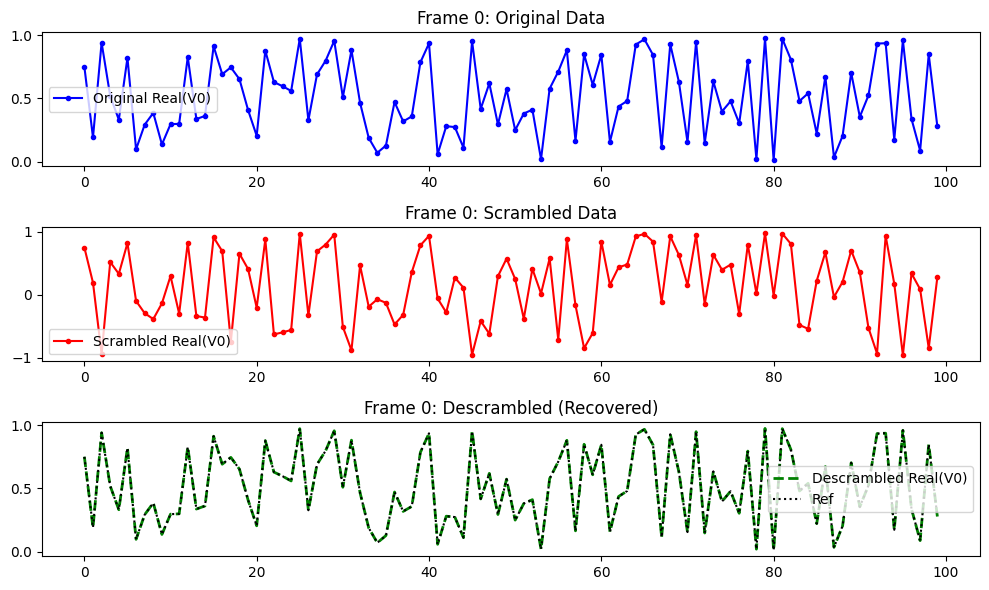

In [ ]:
# KEYS and PARAMETERS
GROUP_ID = 0x2B      
FREQ_ID = 10         

# Simulation parameters
NUM_FRAMES = 1000     
FRAMES = np.arange(NUM_FRAMES)

# Example Personal Keys for testing
KEY_1 = 0x1A2B3C
KEY_2 = 0x0F1E2D

# LFSR & PN GENERATOR
class LFSR26:
    def __init__(self, initial_state, poly_type=1):
        self.mask = 0x3FFFFFF # Mask to ensure 26 bits for KEYS
        self.state = initial_state & self.mask
        self.poly_type = poly_type
    
    def next_bit(self):
        b0  = (self.state >> 0) & 1
        b1  = (self.state >> 1) & 1
        b2  = (self.state >> 2) & 1
        b3  = (self.state >> 3) & 1
        b25 = (self.state >> 25) & 1
        
        # Feedback polynomials (XOR)
        if self.poly_type == 1:
            feedback = b25 ^ b3 ^ b0
        else:
            feedback = b25 ^ b3 ^ b2 ^ b1 ^ b0
            
        self.state = ((self.state << 1) & self.mask) | feedback
        return feedback

def generate_pn_sequences(length, key):
    # Generates mapped PN sequences (+1, -1) for the given frame length (1024)
    lfsr1 = LFSR26(key, poly_type=1)
    lfsr2 = LFSR26(key, poly_type=2)
    
    pn1_raw = []
    pn2_raw = []
    
    for _ in range(length):
        pn1_raw.append(lfsr1.next_bit())
        pn2_raw.append(lfsr2.next_bit())
        
    pn1_raw = np.array(pn1_raw)
    pn2_raw = np.array(pn2_raw)
    
    # Map to scrambling codes: 0->1, 1->-1
    pn_i = (1 - 2 * pn1_raw)
    pn_q = (1 - 2 * pn2_raw)
    
    return pn_i, pn_q

def generate_pn_sequences_polyphase(frame_idx, group_id, length):
    # Generates the 4 complex PN sequences for a specific frame index.
    KEY_0 = (int(frame_idx) << 10) + group_id
    KEY_1 = (int(frame_idx) << 11) + 3 * group_id
    KEY_2 = (int(frame_idx) << 12) + 5 * group_id
    KEY_3 = (int(frame_idx) << 13) + 7 * group_id
    
    pn_i_0_raw, pn_q_0_raw = generate_pn_sequences(length, KEY_0)
    pn_i_1_raw, pn_q_1_raw = generate_pn_sequences(length, KEY_1)
    pn_i_2_raw, pn_q_2_raw = generate_pn_sequences(length, KEY_2)
    pn_i_3_raw, pn_q_3_raw = generate_pn_sequences(length, KEY_3)
    
    return (pn_i_0_raw, pn_q_0_raw, 
            pn_i_1_raw, pn_q_1_raw, 
            pn_i_2_raw, pn_q_2_raw, 
            pn_i_3_raw, pn_q_3_raw)

# SCRAMBLING & DESCRAMBLING LOGIC

def scramble_signal_batch(v0, v1, v2, v3, frames, group_id):
    # Lists to store the PN masks for the whole batch
    mask_i_0, mask_q_0 = [], []
    mask_i_1, mask_q_1 = [], []
    mask_i_2, mask_q_2 = [], []
    mask_i_3, mask_q_3 = [], []

    # print("Generating PN sequences for all frames...")
    for f in frames:
        # Get sequences for this specific frame
        (pni0, pnq0, pni1, pnq1, pni2, pnq2, pni3, pnq3) = generate_pn_sequences_polyphase(f, group_id, N_FFT)
        
        mask_i_0.append(pni0); mask_q_0.append(pnq0)
        mask_i_1.append(pni1); mask_q_1.append(pnq1)
        mask_i_2.append(pni2); mask_q_2.append(pnq2)
        mask_i_3.append(pni3); mask_q_3.append(pnq3)

    # Flatten masks and slice them to match the exact length of the input sub-bands
    mask_i_0 = np.array(mask_i_0).flatten()[:v0.size].reshape(v0.shape)
    mask_q_0 = np.array(mask_q_0).flatten()[:v0.size].reshape(v0.shape)

    mask_i_1 = np.array(mask_i_1).flatten()[:v1.size].reshape(v1.shape)
    mask_q_1 = np.array(mask_q_1).flatten()[:v1.size].reshape(v1.shape) 
    
    mask_i_2 = np.array(mask_i_2).flatten()[:v2.size].reshape(v2.shape)
    mask_q_2 = np.array(mask_q_2).flatten()[:v2.size].reshape(v2.shape)

    mask_i_3 = np.array(mask_i_3).flatten()[:v3.size].reshape(v3.shape)
    mask_q_3 = np.array(mask_q_3).flatten()[:v3.size].reshape(v3.shape)
    
    # Apply Scrambling: Real*PNi + j*Imag*PNq
    v0_hat = (np.real(v0) * mask_i_0) + (1j * np.imag(v0) * mask_q_0)
    v1_hat = (np.real(v1) * mask_i_1) + (1j * np.imag(v1) * mask_q_1)
    v2_hat = (np.real(v2) * mask_i_2) + (1j * np.imag(v2) * mask_q_2)
    v3_hat = (np.real(v3) * mask_i_3) + (1j * np.imag(v3) * mask_q_3)

    return (v0_hat, v1_hat, v2_hat, v3_hat)

def descramble_signal_batch(v0_hat, v1_hat, v2_hat, v3_hat, frames, group_id):
    # Descrambling uses the exact same PN generation logic.
    return scramble_signal_batch(v0_hat, v1_hat, v2_hat, v3_hat, frames, group_id)

# Generating 2 PN sequences using personalized keys
pn_i_1, pn_q_1 = generate_pn_sequences(N_FFT, KEY_1)
pn_i_2, pn_q_2 = generate_pn_sequences(N_FFT, KEY_2)
print(f"Generated PN sequences with KEY_1:{KEY_1} and KEY_2:{KEY_2}")
print(f"First 10 bits of PN1 I: {pn_i_1[:10]}")
print(f"First 10 bits of PN1 Q: {pn_q_1[:10]}")
print(f"First 10 bits of PN2 I: {pn_i_2[:10]}")
print(f"First 10 bits of PN2 Q: {pn_q_2[:10]}")

# Main: Simulate Inputs:
print("Generating dummy input data...")
v0 = (np.random.rand(NUM_FRAMES, N_FFT) + 1j * np.random.rand(NUM_FRAMES, N_FFT))
v1 = (np.random.rand(NUM_FRAMES, N_FFT) + 1j * np.random.rand(NUM_FRAMES, N_FFT))
v2 = (np.random.rand(NUM_FRAMES, N_FFT) + 1j * np.random.rand(NUM_FRAMES, N_FFT))
v3 = (np.random.rand(NUM_FRAMES, N_FFT) + 1j * np.random.rand(NUM_FRAMES, N_FFT))

print("Scrambling...")
scr_v0, scr_v1, scr_v2, scr_v3 = scramble_signal_batch(v0, v1, v2, v3, FRAMES, GROUP_ID) # Scramble
print("Descrambling...")
rec_v0, rec_v1, rec_v2, rec_v3 = descramble_signal_batch(scr_v0, scr_v1, scr_v2, scr_v3, FRAMES, GROUP_ID) # Descramble

# VERIFICATION
mse_list = []
for orig, rec in zip([v0, v1, v2, v3], [rec_v0, rec_v1, rec_v2, rec_v3]):
    mse = np.sqrt(np.mean(np.abs(orig - rec)**2))
    mse_list.append(mse)

print(f"\nMSE for V0-V3: {mse_list}")
if all(m < 1e-10 for m in mse_list):
    print("SUCCESS: Perfect Descrambling verified.")
else:
    print("FAILURE: Errors detected.")

# Plotting one frame (Frame 0)
plt.figure(figsize=(10, 6))
frame_idx = 0
sample_slice = slice(0, 100)

plt.subplot(3, 1, 1)
plt.plot(np.real(v0[frame_idx, sample_slice]), 'b.-', label='Original Real(V0)')
plt.title(f'Frame {frame_idx}: Original Data')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.real(scr_v0[frame_idx, sample_slice]), 'r.-', label='Scrambled Real(V0)')
plt.title(f'Frame {frame_idx}: Scrambled Data')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.real(rec_v0[frame_idx, sample_slice]), 'g--', linewidth=2, label='Descrambled Real(V0)')
plt.plot(np.real(v0[frame_idx, sample_slice]), 'k:', label='Ref')
plt.title(f'Frame {frame_idx}: Descrambled (Recovered)')
plt.legend()

plt.tight_layout()
plt.show()

#### Sub-band Inputs Scrambling and Descrambling (Testing 1 Frame, padded with zeros for all other frames)

In [56]:
def load_data_for_scramble(option, signal_type):
    # Select data based on option and signal type
    if option == 1 and signal_type == 'Type I':
        v0, v1, v2, v3 = v0_I_1, v1_I_1, v2_I_1, v3_I_1
    elif option == 2 and signal_type == 'Type I':
        v0, v1, v2, v3 = v0_I_2, v1_I_2, v2_I_2, v3_I_2
    elif option == 1 and signal_type == 'Type II':
        v0, v1, v2, v3 = v0_II_1, v1_II_1, v2_II_1, v3_II_1
    elif option == 2 and signal_type == 'Type II':
        v0, v1, v2, v3 = v0_II_2, v1_II_2, v2_II_2, v3_II_2
    
    # Pad data to ensure full frames
    max_len = NUM_FRAMES * N_FFT
    def pad_signal(sig, target_len):
        if len(sig) < target_len:
            pad_width = target_len - len(sig)
            sig = np.pad(sig, (0, pad_width), 'constant')
        return sig
    v0 = pad_signal(v0, max_len)
    v1 = pad_signal(v1, max_len)    
    v2 = pad_signal(v2, max_len)
    v3 = pad_signal(v3, max_len)
    
    # Reshape into frames
    v0 = v0.reshape((NUM_FRAMES, N_FFT))
    v1 = v1.reshape((NUM_FRAMES, N_FFT))
    v2 = v2.reshape((NUM_FRAMES, N_FFT))
    v3 = v3.reshape((NUM_FRAMES, N_FFT))
    print("Data Padded and Reshaped", f"v0 shape: {v0.shape}, v1 shape: {v1.shape}, v2 shape: {v2.shape}, v3 shape: {v3.shape}")

    return v0, v1, v2, v3

# Loading all TX data from cell "Time Domain calculation for MSE (Normalized)"
v0_opt1_t1, v1_opt1_t1, v2_opt1_t1, v3_opt1_t1 = load_data_for_scramble(1, 'Type I')
v0_opt2_t1, v1_opt2_t1, v2_opt2_t1, v3_opt2_t1 = load_data_for_scramble(2, 'Type I')
v0_opt1_t2, v1_opt1_t2, v2_opt1_t2, v3_opt1_t2 = load_data_for_scramble(1, 'Type II')
v0_opt2_t2, v1_opt2_t2, v2_opt2_t2, v3_opt2_t2 = load_data_for_scramble(2, 'Type II')

# B. Scramble data
print("Scrambling loaded data...")
scr_v0_opt1_t1, scr_v1_opt1_t1, scr_v2_opt1_t1, scr_v3_opt1_t1 = scramble_signal_batch(v0_opt1_t1, v1_opt1_t1, v2_opt1_t1, v3_opt1_t1, FRAMES, GROUP_ID)
scr_v0_opt2_t1, scr_v1_opt2_t1, scr_v2_opt2_t1, scr_v3_opt2_t1 = scramble_signal_batch(v0_opt2_t1, v1_opt2_t1, v2_opt2_t1, v3_opt2_t1, FRAMES, GROUP_ID)
scr_v0_opt1_t2, scr_v1_opt1_t2, scr_v2_opt1_t2, scr_v3_opt1_t2 = scramble_signal_batch(v0_opt1_t2, v1_opt1_t2, v2_opt1_t2, v3_opt1_t2, FRAMES, GROUP_ID)
scr_v0_opt2_t2, scr_v1_opt2_t2, scr_v2_opt2_t2, scr_v3_opt2_t2 = scramble_signal_batch(v0_opt2_t2, v1_opt2_t2, v2_opt2_t2, v3_opt2_t2, FRAMES, GROUP_ID)
# C. Descramble data
print("Descrambling data...")
rec_v0_opt1_t1, rec_v1_opt1_t1, rec_v2_opt1_t1, rec_v3_opt1_t1 = descramble_signal_batch(scr_v0_opt1_t1, scr_v1_opt1_t1, scr_v2_opt1_t1, scr_v3_opt1_t1, FRAMES, GROUP_ID)
rec_v0_opt2_t1, rec_v1_opt2_t1, rec_v2_opt2_t1, rec_v3_opt2_t1 = descramble_signal_batch(scr_v0_opt2_t1, scr_v1_opt2_t1, scr_v2_opt2_t1, scr_v3_opt2_t1, FRAMES, GROUP_ID)
rec_v0_opt1_t2, rec_v1_opt1_t2, rec_v2_opt1_t2, rec_v3_opt1_t2 = descramble_signal_batch(scr_v0_opt1_t2, scr_v1_opt1_t2, scr_v2_opt1_t2, scr_v3_opt1_t2, FRAMES, GROUP_ID)
rec_v0_opt2_t2, rec_v1_opt2_t2, rec_v2_opt2_t2, rec_v3_opt2_t2 = descramble_signal_batch(scr_v0_opt2_t2, scr_v1_opt2_t2, scr_v2_opt2_t2, scr_v3_opt2_t2, FRAMES, GROUP_ID)

# Verify MSE
def verify_mse(original, recovered, option, signal_type):
    mse_list = []
    for orig, rec in zip(original, recovered):
        mse = np.sqrt(np.mean(np.abs(orig - rec)**2))
        mse_list.append(mse)
    avg_mse = np.mean(mse_list)
    print(f"Average MSE for Option {option}, Signal Type {signal_type}: {avg_mse:.4e}")
    return avg_mse

mse_opt1_t1 = verify_mse([v0_opt1_t1, v1_opt1_t1, v2_opt1_t1, v3_opt1_t1], 
                         [rec_v0_opt1_t1, rec_v1_opt1_t1, rec_v2_opt1_t1, rec_v3_opt1_t1], 1, 'Type I')
mse_opt2_t1 = verify_mse([v0_opt2_t1, v1_opt2_t1, v2_opt2_t1, v3_opt2_t1], 
                         [rec_v0_opt2_t1, rec_v1_opt2_t1, rec_v2_opt2_t1, rec_v3_opt2_t1], 2, 'Type I')
mse_opt1_t2 = verify_mse([v0_opt1_t2, v1_opt1_t2, v2_opt1_t2, v3_opt1_t2], 
                         [rec_v0_opt1_t2, rec_v1_opt1_t2, rec_v2_opt1_t2, rec_v3_opt1_t2], 1, 'Type II')
mse_opt2_t2 = verify_mse([v0_opt2_t2, v1_opt2_t2, v2_opt2_t2, v3_opt2_t2], 
                         [rec_v0_opt2_t2, rec_v1_opt2_t2, rec_v2_opt2_t2, rec_v3_opt2_t2], 2, 'Type II')    
if all(mse < 1e-10 for mse in [mse_opt1_t1, mse_opt2_t1, mse_opt1_t2, mse_opt2_t2]):
    print("SUCCESS: Perfect Descrambling verified for all options and signal types.")
else:
    print("FAILURE: Errors detected in some options or signal types.")

Data Padded and Reshaped v0 shape: (1000, 1024), v1 shape: (1000, 1024), v2 shape: (1000, 1024), v3 shape: (1000, 1024)
Data Padded and Reshaped v0 shape: (1000, 1024), v1 shape: (1000, 1024), v2 shape: (1000, 1024), v3 shape: (1000, 1024)
Data Padded and Reshaped v0 shape: (1000, 1024), v1 shape: (1000, 1024), v2 shape: (1000, 1024), v3 shape: (1000, 1024)
Data Padded and Reshaped v0 shape: (1000, 1024), v1 shape: (1000, 1024), v2 shape: (1000, 1024), v3 shape: (1000, 1024)
Scrambling loaded data...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Descrambling data...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Average MSE for Option 1, Signal Type Type I: 0.0000e+00
Average MSE for Option 2, Signal Type Type I: 0.0000e+00
Average MSE for Option 

#### Time Domain calculation for MSE (Scrambled & Descrambled)

In [57]:
# Processing Chain After Descrambling (Descramble -> Upsample -> Feq)
def process_chain_descrambled(x_down_scrambled, heq, feq, factor):
    # Upsample
    y_up = np.zeros(len(x_down_scrambled) * factor, dtype=complex)
    y_up[::factor] = x_down_scrambled
    # Synthesis
    z = signal.convolve(y_up, feq, mode='full')
    # Scale correction
    return z * (1/factor)

def load_process_signal_before_scrambling(signal_type, option_num):
    x = load_signal(signal_type)

    y0, v0 = process_chain(x, Heq_V0, feqs[option_num-1][0], 8)
    y1, v1 = process_chain(x, Heq_V1, feqs[option_num-1][1], 8)
    y2, v2 = process_chain(x, Heq_V2, feqs[option_num-1][2], 4)
    y3, v3 = process_chain(x, Heq_V3, feqs[option_num-1][3], 2)
    
    return v0, v1, v2, v3

def load_process_signal_after_descrambling(signal_type, option_num):
    # Load scrambled and descrambled data based on option and signal type
    if option_num == 1 and signal_type == 'Type I':
        rec_v0, rec_v1, rec_v2, rec_v3 = rec_v0_opt1_t1, rec_v1_opt1_t1, rec_v2_opt1_t1, rec_v3_opt1_t1
    elif option_num == 2 and signal_type == 'Type I':
        rec_v0, rec_v1, rec_v2, rec_v3 = rec_v0_opt2_t1, rec_v1_opt2_t1, rec_v2_opt2_t1, rec_v3_opt2_t1
    elif option_num == 1 and signal_type == 'Type II':
        rec_v0, rec_v1, rec_v2, rec_v3 = rec_v0_opt1_t2, rec_v1_opt1_t2, rec_v2_opt1_t2, rec_v3_opt1_t2
    elif option_num == 2 and signal_type == 'Type II':
        rec_v0, rec_v1, rec_v2, rec_v3 = rec_v0_opt2_t2, rec_v1_opt2_t2, rec_v2_opt2_t2, rec_v3_opt2_t2

    # Concatenate frames back to a single signal
    x_down_scrambled = np.concatenate([rec_v0.flatten(), rec_v1.flatten(), rec_v2.flatten(), rec_v3.flatten()])

    # Process each sub-band through synthesis filters
    y0 = process_chain_descrambled(rec_v0.flatten(), Heq_V0, feqs[option_num-1][0], 8)
    y1 = process_chain_descrambled(rec_v1.flatten(), Heq_V1, feqs[option_num-1][1], 8)
    y2 = process_chain_descrambled(rec_v2.flatten(), Heq_V2, feqs[option_num-1][2], 4)
    y3 = process_chain_descrambled(rec_v3.flatten(), Heq_V3, feqs[option_num-1][3], 2)

    max_len = int(np.max([len(y0), len(y1), len(y2), len(y3)]))  
    total_out = np.zeros(max_len, dtype=complex)
    for y in [y0, y1, y2, y3]: total_out[:len(y)] += y
    return total_out

def calculate_mse_for_frame_scr_descr(sig_type, option_num, system_gain):
    total_out = load_process_signal_after_descrambling(sig_type, option_num)

    x = load_signal(sig_type)
    # Increase x length and duplicate for NUM_FRAMES
    x = np.tile(x, NUM_FRAMES)
    total_out /= system_gain # Normalize by system gain (Calculated from impulse response)
    x_hat = total_out[:len(x)] # Truncate to original signal length
    
    err = np.abs(x - x_hat)/np.abs(x)  # Formula: Sum(|x - x_hat|^2) / Sum(|x|^2) / 1024  
    mse = np.sqrt(np.mean(np.abs(err)**2))  # (RMS)
    
    return mse, v0, v1, v2, v3 # Return the sub-bands for scrambling analysis

print("Calculating System Gain For Normalization")
gain_opt1, _, _ , _ , _ = calibrate_system_gain(1)
gain_opt2, _, _ , _ , _ = calibrate_system_gain(2)
print(f"System Gain Option 1: {gain_opt1:.2e}")
print(f"System Gain Option 2: {gain_opt2:.2e}")

N_FRAMES = 1000 
print(f"\nRunning MSE Simulation for {N_FRAMES} frames with Scrambling and Descrambling...")
results = { ('Type I', 1): [], ('Type I', 2): [], ('Type II', 1): [], ('Type II', 2): [] }

# Initialize lists to store full sub-band data
v0_I_1_full, v1_I_1_full, v2_I_1_full, v3_I_1_full = [], [], [], []
v0_I_2_full, v1_I_2_full, v2_I_2_full, v3_I_2_full = [], [], [], []
v0_II_1_full, v1_II_1_full, v2_II_1_full, v3_II_1_full = [], [], [], []
v0_II_2_full, v1_II_2_full, v2_II_2_full, v3_II_2_full = [], [], [], []

for i in range(N_FRAMES):
    v0_I_1, v1_I_1, v2_I_1, v3_I_1 = load_process_signal_before_scrambling('Type I', 1)
    v0_I_2, v1_I_2, v2_I_2, v3_I_2 = load_process_signal_before_scrambling('Type I', 2)
    v0_II_1, v1_II_1, v2_II_1, v3_II_1 = load_process_signal_before_scrambling('Type II', 1)
    v0_II_2, v1_II_2, v2_II_2, v3_II_2 = load_process_signal_before_scrambling('Type II', 2)
    v0_I_1_full.append(v0_I_1)
    v1_I_1_full.append(v1_I_1)
    v2_I_1_full.append(v2_I_1)
    v3_I_1_full.append(v3_I_1)
    v0_I_2_full.append(v0_I_2)
    v1_I_2_full.append(v1_I_2)
    v2_I_2_full.append(v2_I_2)
    v3_I_2_full.append(v3_I_2)
    v0_II_1_full.append(v0_II_1)
    v1_II_1_full.append(v1_II_1)
    v2_II_1_full.append(v2_II_1)
    v3_II_1_full.append(v3_II_1)
    v0_II_2_full.append(v0_II_2)
    v1_II_2_full.append(v1_II_2)
    v2_II_2_full.append(v2_II_2)
    v3_II_2_full.append(v3_II_2)

#Scramble and Descramble the full data
print("Scrambling loaded data...")
scr_v0_opt1_t1, scr_v1_opt1_t1, scr_v2_opt1_t1, scr_v3_opt1_t1 = scramble_signal_batch(
    np.concatenate(v0_I_1_full), np.concatenate(v1_I_1_full), np.concatenate(v2_I_1_full), np.concatenate(v3_I_1_full), FRAMES, GROUP_ID)
scr_v0_opt2_t1, scr_v1_opt2_t1, scr_v2_opt2_t1, scr_v3_opt2_t1 = scramble_signal_batch(
    np.concatenate(v0_I_2_full), np.concatenate(v1_I_2_full), np.concatenate(v2_I_2_full), np.concatenate(v3_I_2_full), FRAMES, GROUP_ID)
scr_v0_opt1_t2, scr_v1_opt1_t2, scr_v2_opt1_t2, scr_v3_opt1_t2 = scramble_signal_batch(
    np.concatenate(v0_II_1_full), np.concatenate(v1_II_1_full), np.concatenate(v2_II_1_full), np.concatenate(v3_II_1_full), FRAMES, GROUP_ID)
scr_v0_opt2_t2, scr_v1_opt2_t2, scr_v2_opt2_t2, scr_v3_opt2_t2 = scramble_signal_batch(
    np.concatenate(v0_II_2_full), np.concatenate(v1_II_2_full), np.concatenate(v2_II_2_full), np.concatenate(v3_II_2_full), FRAMES, GROUP_ID)

print("Descrambling data...")
rec_v0_opt1_t1, rec_v1_opt1_t1, rec_v2_opt1_t1, rec_v3_opt1_t1 = descramble_signal_batch(
    scr_v0_opt1_t1, scr_v1_opt1_t1, scr_v2_opt1_t1, scr_v3_opt1_t1, FRAMES, GROUP_ID)   
rec_v0_opt2_t1, rec_v1_opt2_t1, rec_v2_opt2_t1, rec_v3_opt2_t1 = descramble_signal_batch(
    scr_v0_opt2_t1, scr_v1_opt2_t1, scr_v2_opt2_t1, scr_v3_opt2_t1, FRAMES, GROUP_ID)
rec_v0_opt1_t2, rec_v1_opt1_t2, rec_v2_opt1_t2, rec_v3_opt1_t2 = descramble_signal_batch(
    scr_v0_opt1_t2, scr_v1_opt1_t2, scr_v2_opt1_t2, scr_v3_opt1_t2, FRAMES, GROUP_ID)
rec_v0_opt2_t2, rec_v1_opt2_t2, rec_v2_opt2_t2, rec_v3_opt2_t2 = descramble_signal_batch(
    scr_v0_opt2_t2, scr_v1_opt2_t2, scr_v2_opt2_t2, scr_v3_opt2_t2, FRAMES, GROUP_ID)

# Calculate MSE after descrambling (NFFT * NUM_FRAMES length signals)
mse_I_1, _, _ , _ , _ = calculate_mse_for_frame_scr_descr('Type I', 1, gain_opt1)
mse_I_2, _, _ , _ , _ = calculate_mse_for_frame_scr_descr('Type I', 2, gain_opt2)
mse_II_1, _, _ , _ , _ = calculate_mse_for_frame_scr_descr('Type II', 1, gain_opt1)
mse_II_2, _, _ , _ , _ = calculate_mse_for_frame_scr_descr('Type II', 2, gain_opt2)
results[('Type I', 1)].append(mse_I_1)
results[('Type I', 2)].append(mse_I_2)
results[('Type II', 1)].append(mse_II_1)
results[('Type II', 2)].append(mse_II_2)

avg_mse_t1_o1 = np.mean(results[('Type I', 1)])
avg_mse_t1_o2 = np.mean(results[('Type I', 2)])
avg_mse_t2_o1 = np.mean(results[('Type II', 1)])
avg_mse_t2_o2 = np.mean(results[('Type II', 2)])

print("\n" + "="*80)
print(f"{'Signal Type':<25} | {'Option 1 MSE (Normalized)':<25} | {'Option 2 MSE (Normalized)':<25}")
print("-" * 80)
print(f"{'Type I (Random)':<25} | {avg_mse_t1_o1:<25.4e} | {avg_mse_t1_o2:<25.4e}")
print(f"{'Type II (Bandpass)':<25} | {avg_mse_t2_o1:<25.4e} | {avg_mse_t2_o2:<25.4e}")
print("="*80)

Calculating System Gain For Normalization
System Gain Option 1: 1.80e+17
System Gain Option 2: 2.66e+17

Running MSE Simulation for 1000 frames with Scrambling and Descrambling...
Scrambling loaded data...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Descrambling data...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...

Signal Type               | Option 1 MSE (Normalized) | Option 2 MSE (Normalized)
--------------------------------------------------------------------------------
Type I (Random)           | 5.6998e+00                | 4.0396e+00               
Type II (Bandpass)        | 1.4963e+00                | 1.2533e+00               


#### MSE vs SNR Calculation

##### Input Type-I Option-1

Calculating System Gain For Normalization

Generating base signal data (1000 frames)...
Scrambling base signal...
Generating PN sequences for all frames...

Running Simulation (MSE vs SNR)...
Processing Frequency Offset: 0 Hz
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequ

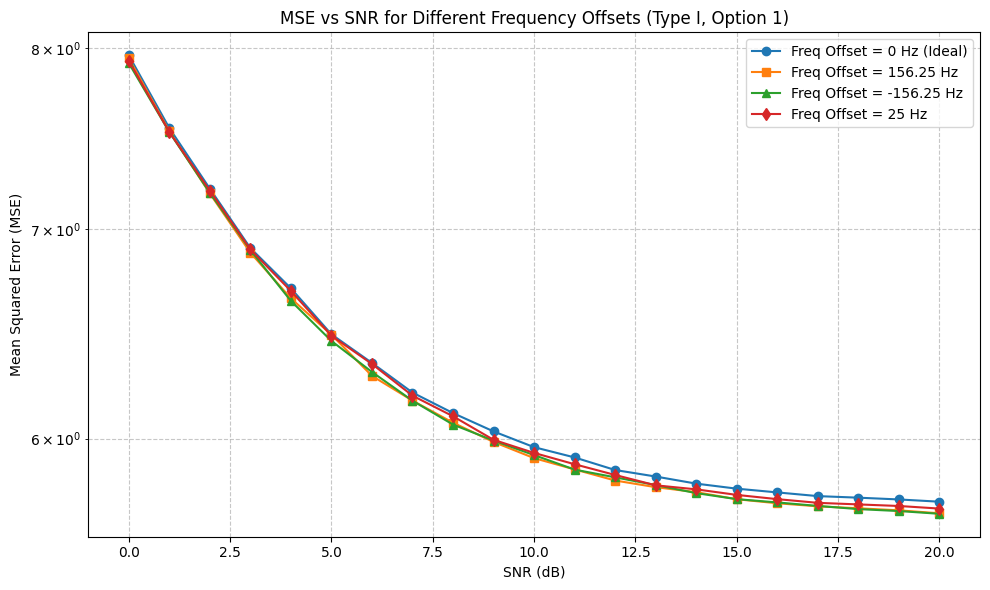

Done.


In [ ]:
# Processing Functions
def process_chain_descrambled(x_down_scrambled, heq, feq, factor):
    """Processes a single sub-band after descrambling."""
    # Upsample
    y_up = np.zeros(len(x_down_scrambled) * factor, dtype=complex)
    y_up[::factor] = x_down_scrambled
    # Synthesis
    z = signal.convolve(y_up, feq, mode='full')
    # Scale correction
    return z * (1/factor)

def reconstruct_signal(rec_bands, option_num):
    rec_v0, rec_v1, rec_v2, rec_v3 = rec_bands
    # Process each sub-band through synthesis filters
    y0 = process_chain_descrambled(rec_v0.flatten(), Heq_V0, feqs[option_num-1][0], 8)
    y1 = process_chain_descrambled(rec_v1.flatten(), Heq_V1, feqs[option_num-1][1], 8)
    y2 = process_chain_descrambled(rec_v2.flatten(), Heq_V2, feqs[option_num-1][2], 4)
    y3 = process_chain_descrambled(rec_v3.flatten(), Heq_V3, feqs[option_num-1][3], 2)

    # Summing the signals
    max_len = np.max([len(y0), len(y1), len(y2), len(y3)])  
    total_out = np.zeros(max_len, dtype=complex)
    
    for y in [y0, y1, y2, y3]:
        total_out[:len(y)] += y
        
    return total_out

def calculate_mse(total_out, sig_type, system_gain, num_frames):
    x = load_signal(sig_type)
    x_full = np.tile(x, num_frames)
    
    # Normalize by system gain
    total_out_norm = total_out / system_gain
    
    # Truncate reconstruction to match original signal length
    x_hat = total_out_norm[:len(x_full)] 
    
    # Calculate Erro
    err = np.abs(x_full - x_hat)/np.abs(x_full)
    mse = np.sqrt(np.mean(err**2)) # RMS
    
    return mse

def apply_channel_effects(bands, snr_db, freq_offset_hz, fs=44100):
    """
    Applies Frequency Offset and AWGN to the sub-bands.
    
    Args:
        bands: List of sub-band arrays.
        snr_db: Signal-to-Noise Ratio in dB.
        freq_offset_hz: Frequency offset in Hz.
        fs: Sampling frequency (assumed 44100 Hz for audio context).
    """
    noisy_bands = []
    
    for b in bands:
        # Apply Frequency Offset
        # x(t) -> x(t) * e^(j * 2*pi * delta_f * t)
        t = np.arange(len(b)) / fs
        offset_phasor = np.exp(1j * 2 * np.pi * freq_offset_hz * t)
        b_shifted = b * offset_phasor
        
        # Add AWGN
        sig_power = np.mean(np.abs(b_shifted)**2)
        
        # Calculate noise power based on SNR
        # SNR_dB = 10 * log10(P_signal / P_noise)
        # P_noise = P_signal / 10^(SNR_dB / 10)
        noise_power = sig_power / (10**(snr_db / 10))
        
        # Generate complex Gaussian noise
        # Scale by sqrt(P_noise / 2) for real and imag parts
        noise_scale = np.sqrt(noise_power / 2)
        noise = noise_scale * (np.random.randn(len(b)) + 1j * np.random.randn(len(b)))
        
        noisy_bands.append(b_shifted + noise)
        
    return noisy_bands

# Calibrate Gains
print("Calculating System Gain For Normalization")
system_gains = {}
for opt in [1, 2]:
    gain, _, _, _, _ = calibrate_system_gain(opt)
    system_gains[opt] = gain

# Simulation Setup
N_FRAMES = 1000  # Reduced frames for faster plotting loop, increase to 1000 for high precision
configs = [('Type I', 1)] # Using Type I (Random), Option 1 for the requested Plot

# Initialize storage
raw_data_store = {key: [[], [], [], []] for key in configs}

print(f"\nGenerating base signal data ({N_FRAMES} frames)...")
for i in range(N_FRAMES):
    for sig_type, opt in configs:
        bands = load_process_signal_before_scrambling(sig_type, opt) #Load and process TX data
        for band_idx, band_data in enumerate(bands):
            raw_data_store[(sig_type, opt)][band_idx].append(band_data)

# Flatten bands for processing
target_key = ('Type I', 1)
band_lists = raw_data_store[target_key]
flat_bands = [np.concatenate(b_list) for b_list in band_lists]

# Scramble (Base scrambled signal to be transmitted)
print("Scrambling base signal...")
tx_scrambled_bands = scramble_signal_batch(*flat_bands, FRAMES, GROUP_ID)

# SNR and Offset Loop
snr_range = np.arange(0, 21, 1) # 0 to 20 dB
freq_offsets = [0, 2*78.125, -2*78.125, 25] # Hz
results_plot = {off: [] for off in freq_offsets}

print("\nRunning Simulation (MSE vs SNR)...")

for offset in freq_offsets:
    print(f"Processing Frequency Offset: {offset} Hz")
    mse_curve = []
    
    for snr in snr_range:
        # Apply Channel (Offset + Noise)
        rx_bands = apply_channel_effects(tx_scrambled_bands, snr, offset, fs=20000) # Note: FS=20000 is a placeholder
        
        # Descramble
        recovered_bands = descramble_signal_batch(*rx_bands, FRAMES, GROUP_ID)
        
        # Reconstruct
        total_output = reconstruct_signal(recovered_bands, 1)
        
        # Calculate MSE
        mse = calculate_mse(total_output, 'Type I', system_gains[1], N_FRAMES)
        mse_curve.append(mse)
        
    results_plot[offset] = mse_curve

# 4. Plotting
print("\nPlotting results...")
plt.figure(figsize=(10, 6))

markers = ['o', 's', '^', 'd']
for idx, offset in enumerate(freq_offsets):
    label_str = f"Freq Offset = {offset} Hz"
    if offset == 0: label_str += " (Ideal)"
    plt.plot(snr_range, results_plot[offset], marker=markers[idx], label=label_str)

plt.title('MSE vs SNR for Different Frequency Offsets (Type I, Option 1)')
plt.xlabel('SNR (dB)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.yscale('log') # MSE is often better viewed in Log scale
plt.tight_layout()
plt.show()

print("Done.")

##### Input Type-I Option-2

Calculating System Gain For Normalization

Generating base signal data (1000 frames)...
Scrambling base signal...
Generating PN sequences for all frames...

Running Simulation (MSE vs SNR)...
Processing Frequency Offset: 0 Hz
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequ

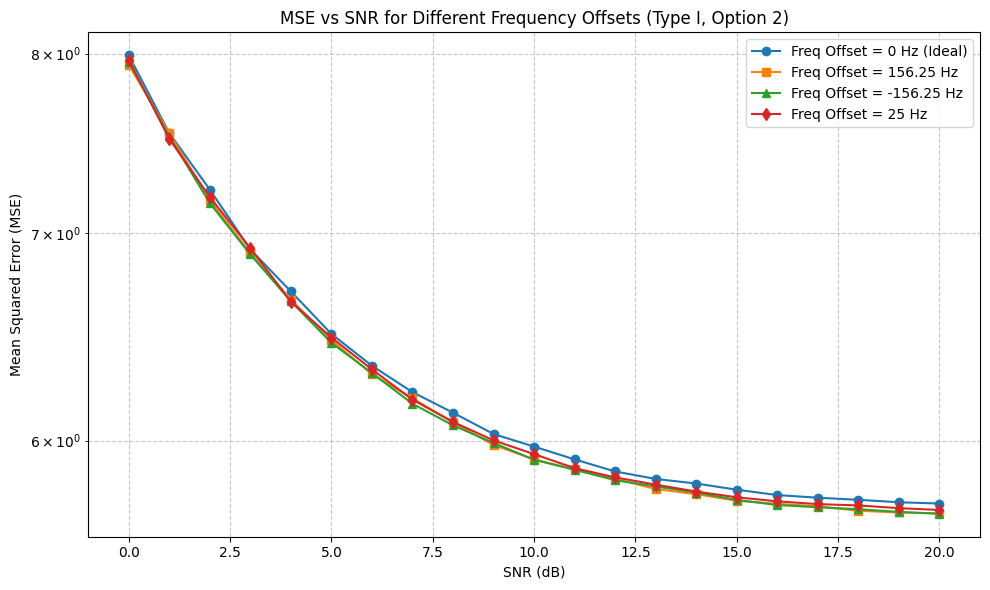

Done.


In [66]:
# Processing Functions
def process_chain_descrambled(x_down_scrambled, heq, feq, factor):
    """Processes a single sub-band after descrambling."""
    # Upsample
    y_up = np.zeros(len(x_down_scrambled) * factor, dtype=complex)
    y_up[::factor] = x_down_scrambled
    # Synthesis
    z = signal.convolve(y_up, feq, mode='full')
    # Scale correction
    return z * (1/factor)

def reconstruct_signal(rec_bands, option_num):
    rec_v0, rec_v1, rec_v2, rec_v3 = rec_bands
    # Process each sub-band through synthesis filters
    y0 = process_chain_descrambled(rec_v0.flatten(), Heq_V0, feqs[option_num-1][0], 8)
    y1 = process_chain_descrambled(rec_v1.flatten(), Heq_V1, feqs[option_num-1][1], 8)
    y2 = process_chain_descrambled(rec_v2.flatten(), Heq_V2, feqs[option_num-1][2], 4)
    y3 = process_chain_descrambled(rec_v3.flatten(), Heq_V3, feqs[option_num-1][3], 2)

    # Summing the signals
    max_len = np.max([len(y0), len(y1), len(y2), len(y3)])  
    total_out = np.zeros(max_len, dtype=complex)
    
    for y in [y0, y1, y2, y3]:
        total_out[:len(y)] += y
        
    return total_out

def calculate_mse(total_out, sig_type, system_gain, num_frames):
    x = load_signal(sig_type)
    x_full = np.tile(x, num_frames)
    
    # Normalize by system gain
    total_out_norm = total_out / system_gain
    
    # Truncate reconstruction to match original signal length
    x_hat = total_out_norm[:len(x_full)] 
    
    # Calculate Erro
    err = np.abs(x_full - x_hat)/np.abs(x_full)
    mse = np.sqrt(np.mean(err**2)) # RMS
    
    return mse

def apply_channel_effects(bands, snr_db, freq_offset_hz, fs=44100):
    """
    Applies Frequency Offset and AWGN to the sub-bands.
    
    Args:
        bands: List of sub-band arrays.
        snr_db: Signal-to-Noise Ratio in dB.
        freq_offset_hz: Frequency offset in Hz.
        fs: Sampling frequency (assumed 44100 Hz for audio context).
    """
    noisy_bands = []
    
    for b in bands:
        # Apply Frequency Offset
        # x(t) -> x(t) * e^(j * 2*pi * delta_f * t)
        t = np.arange(len(b)) / fs
        offset_phasor = np.exp(1j * 2 * np.pi * freq_offset_hz * t)
        b_shifted = b * offset_phasor
        
        # Add AWGN
        sig_power = np.mean(np.abs(b_shifted)**2)
        
        # Calculate noise power based on SNR
        # SNR_dB = 10 * log10(P_signal / P_noise)
        # P_noise = P_signal / 10^(SNR_dB / 10)
        noise_power = sig_power / (10**(snr_db / 10))
        
        # Generate complex Gaussian noise
        # Scale by sqrt(P_noise / 2) for real and imag parts
        noise_scale = np.sqrt(noise_power / 2)
        noise = noise_scale * (np.random.randn(len(b)) + 1j * np.random.randn(len(b)))
        
        noisy_bands.append(b_shifted + noise)
        
    return noisy_bands

# Calibrate Gains
print("Calculating System Gain For Normalization")
system_gains = {}
for opt in [1, 2]:
    gain, _, _, _, _ = calibrate_system_gain(opt)
    system_gains[opt] = gain

# Simulation Setup
N_FRAMES = 1000  # Reduced frames for faster plotting loop, increase to 1000 for high precision
configs = [('Type I', 2)] # Using Type I (Random), Option 2 for the requested Plot

# Initialize storage
raw_data_store = {key: [[], [], [], []] for key in configs}

print(f"\nGenerating base signal data ({N_FRAMES} frames)...")
for i in range(N_FRAMES):
    for sig_type, opt in configs:
        bands = load_process_signal_before_scrambling(sig_type, opt) #Load and process TX data
        for band_idx, band_data in enumerate(bands):
            raw_data_store[(sig_type, opt)][band_idx].append(band_data)

# Flatten bands for processing
target_key = ('Type I', 2)
band_lists = raw_data_store[target_key]
flat_bands = [np.concatenate(b_list) for b_list in band_lists]

# Scramble (Base scrambled signal to be transmitted)
print("Scrambling base signal...")
tx_scrambled_bands = scramble_signal_batch(*flat_bands, FRAMES, GROUP_ID)

# SNR and Offset Loop
snr_range = np.arange(0, 21, 1) # 0 to 20 dB
freq_offsets = [0, 2*78.125, -2*78.125, 25] # Hz
results_plot = {off: [] for off in freq_offsets}

print("\nRunning Simulation (MSE vs SNR)...")

for offset in freq_offsets:
    print(f"Processing Frequency Offset: {offset} Hz")
    mse_curve = []
    
    for snr in snr_range:
        # Apply Channel (Offset + Noise)
        rx_bands = apply_channel_effects(tx_scrambled_bands, snr, offset, fs=20000) # Note: FS=20000 is a placeholder
        
        # Descramble
        recovered_bands = descramble_signal_batch(*rx_bands, FRAMES, GROUP_ID)
        
        # Reconstruct
        total_output = reconstruct_signal(recovered_bands, 1)
        
        # Calculate MSE
        mse = calculate_mse(total_output, 'Type I', system_gains[1], N_FRAMES)
        mse_curve.append(mse)
        
    results_plot[offset] = mse_curve

# 4. Plotting
print("\nPlotting results...")
plt.figure(figsize=(10, 6))

markers = ['o', 's', '^', 'd']
for idx, offset in enumerate(freq_offsets):
    label_str = f"Freq Offset = {offset} Hz"
    if offset == 0: label_str += " (Ideal)"
    plt.plot(snr_range, results_plot[offset], marker=markers[idx], label=label_str)

plt.title('MSE vs SNR for Different Frequency Offsets (Type I, Option 2)')
plt.xlabel('SNR (dB)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.yscale('log') # MSE is often better viewed in Log scale
plt.tight_layout()
plt.show()

print("Done.")

##### Input Type-II Option-1

Calculating System Gain For Normalization

Generating base signal data (1000 frames)...
Scrambling base signal...
Generating PN sequences for all frames...

Running Simulation (MSE vs SNR)...
Processing Frequency Offset: 0 Hz
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequ

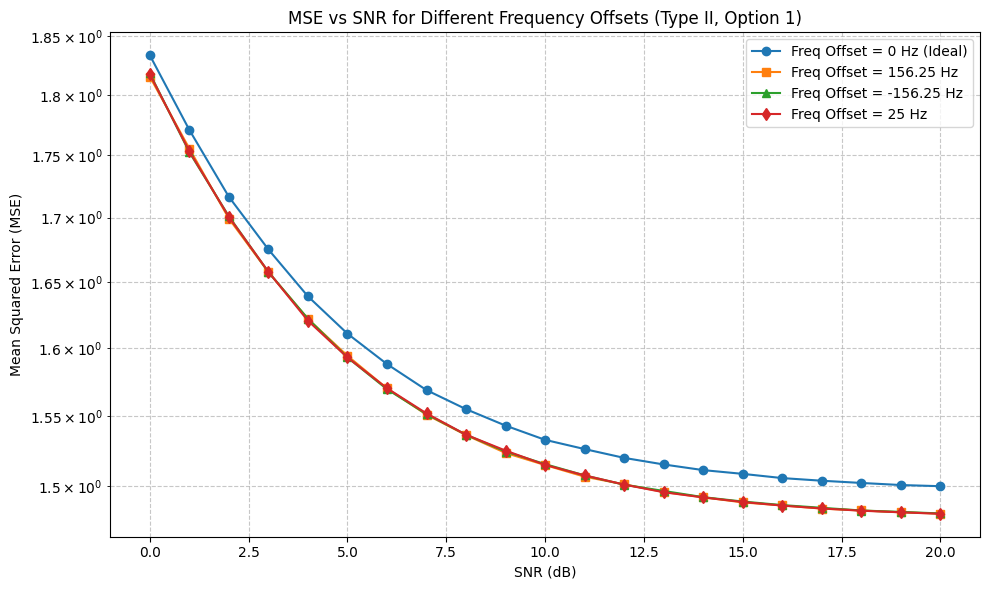

Done.


In [67]:
# Processing Functions
def process_chain_descrambled(x_down_scrambled, heq, feq, factor):
    """Processes a single sub-band after descrambling."""
    # Upsample
    y_up = np.zeros(len(x_down_scrambled) * factor, dtype=complex)
    y_up[::factor] = x_down_scrambled
    # Synthesis
    z = signal.convolve(y_up, feq, mode='full')
    # Scale correction
    return z * (1/factor)

def reconstruct_signal(rec_bands, option_num):
    rec_v0, rec_v1, rec_v2, rec_v3 = rec_bands
    # Process each sub-band through synthesis filters
    y0 = process_chain_descrambled(rec_v0.flatten(), Heq_V0, feqs[option_num-1][0], 8)
    y1 = process_chain_descrambled(rec_v1.flatten(), Heq_V1, feqs[option_num-1][1], 8)
    y2 = process_chain_descrambled(rec_v2.flatten(), Heq_V2, feqs[option_num-1][2], 4)
    y3 = process_chain_descrambled(rec_v3.flatten(), Heq_V3, feqs[option_num-1][3], 2)

    # Summing the signals
    max_len = np.max([len(y0), len(y1), len(y2), len(y3)])  
    total_out = np.zeros(max_len, dtype=complex)
    
    for y in [y0, y1, y2, y3]:
        total_out[:len(y)] += y
        
    return total_out

def calculate_mse(total_out, sig_type, system_gain, num_frames):
    x = load_signal(sig_type)
    x_full = np.tile(x, num_frames)
    
    # Normalize by system gain
    total_out_norm = total_out / system_gain
    
    # Truncate reconstruction to match original signal length
    x_hat = total_out_norm[:len(x_full)] 
    
    # Calculate Erro
    err = np.abs(x_full - x_hat)/np.abs(x_full)
    mse = np.sqrt(np.mean(err**2)) # RMS
    
    return mse

def apply_channel_effects(bands, snr_db, freq_offset_hz, fs=44100):
    """
    Applies Frequency Offset and AWGN to the sub-bands.
    
    Args:
        bands: List of sub-band arrays.
        snr_db: Signal-to-Noise Ratio in dB.
        freq_offset_hz: Frequency offset in Hz.
        fs: Sampling frequency (assumed 44100 Hz for audio context).
    """
    noisy_bands = []
    
    for b in bands:
        # Apply Frequency Offset
        # x(t) -> x(t) * e^(j * 2*pi * delta_f * t)
        t = np.arange(len(b)) / fs
        offset_phasor = np.exp(1j * 2 * np.pi * freq_offset_hz * t)
        b_shifted = b * offset_phasor
        
        # Add AWGN
        sig_power = np.mean(np.abs(b_shifted)**2)
        
        # Calculate noise power based on SNR
        # SNR_dB = 10 * log10(P_signal / P_noise)
        # P_noise = P_signal / 10^(SNR_dB / 10)
        noise_power = sig_power / (10**(snr_db / 10))
        
        # Generate complex Gaussian noise
        # Scale by sqrt(P_noise / 2) for real and imag parts
        noise_scale = np.sqrt(noise_power / 2)
        noise = noise_scale * (np.random.randn(len(b)) + 1j * np.random.randn(len(b)))
        
        noisy_bands.append(b_shifted + noise)
        
    return noisy_bands

# Calibrate Gains
print("Calculating System Gain For Normalization")
system_gains = {}
for opt in [1, 2]:
    gain, _, _, _, _ = calibrate_system_gain(opt)
    system_gains[opt] = gain

# Simulation Setup
N_FRAMES = 1000  # Reduced frames for faster plotting loop, increase to 1000 for high precision
configs = [('Type II', 1)] # Using Type II (Random), Option 1 for the requested Plot

# Initialize storage
raw_data_store = {key: [[], [], [], []] for key in configs}

print(f"\nGenerating base signal data ({N_FRAMES} frames)...")
for i in range(N_FRAMES):
    for sig_type, opt in configs:
        bands = load_process_signal_before_scrambling(sig_type, opt) #Load and process TX data
        for band_idx, band_data in enumerate(bands):
            raw_data_store[(sig_type, opt)][band_idx].append(band_data)

# Flatten bands for processing
target_key = ('Type II', 1)
band_lists = raw_data_store[target_key]
flat_bands = [np.concatenate(b_list) for b_list in band_lists]

# Scramble (Base scrambled signal to be transmitted)
print("Scrambling base signal...")
tx_scrambled_bands = scramble_signal_batch(*flat_bands, FRAMES, GROUP_ID)

# SNR and Offset Loop
snr_range = np.arange(0, 21, 1) # 0 to 20 dB
freq_offsets = [0, 2*78.125, -2*78.125, 25] # Hz
results_plot = {off: [] for off in freq_offsets}

print("\nRunning Simulation (MSE vs SNR)...")

for offset in freq_offsets:
    print(f"Processing Frequency Offset: {offset} Hz")
    mse_curve = []
    
    for snr in snr_range:
        # Apply Channel (Offset + Noise)
        rx_bands = apply_channel_effects(tx_scrambled_bands, snr, offset, fs=20000) # Note: FS=20000 is a placeholder
        
        # Descramble
        recovered_bands = descramble_signal_batch(*rx_bands, FRAMES, GROUP_ID)
        
        # Reconstruct
        total_output = reconstruct_signal(recovered_bands, 1)
        
        # Calculate MSE
        mse = calculate_mse(total_output, 'Type II', system_gains[1], N_FRAMES)
        mse_curve.append(mse)
        
    results_plot[offset] = mse_curve

# 4. Plotting
print("\nPlotting results...")
plt.figure(figsize=(10, 6))

markers = ['o', 's', '^', 'd']
for idx, offset in enumerate(freq_offsets):
    label_str = f"Freq Offset = {offset} Hz"
    if offset == 0: label_str += " (Ideal)"
    plt.plot(snr_range, results_plot[offset], marker=markers[idx], label=label_str)

plt.title('MSE vs SNR for Different Frequency Offsets (Type II, Option 1)')
plt.xlabel('SNR (dB)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.yscale('log') # MSE is often better viewed in Log scale
plt.tight_layout()
plt.show()

print("Done.")

##### Input Type-II Option-2

Calculating System Gain For Normalization

Generating base signal data (1000 frames)...
Scrambling base signal...
Generating PN sequences for all frames...

Running Simulation (MSE vs SNR)...
Processing Frequency Offset: 0 Hz
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequences for all frames...
Generating PN sequ

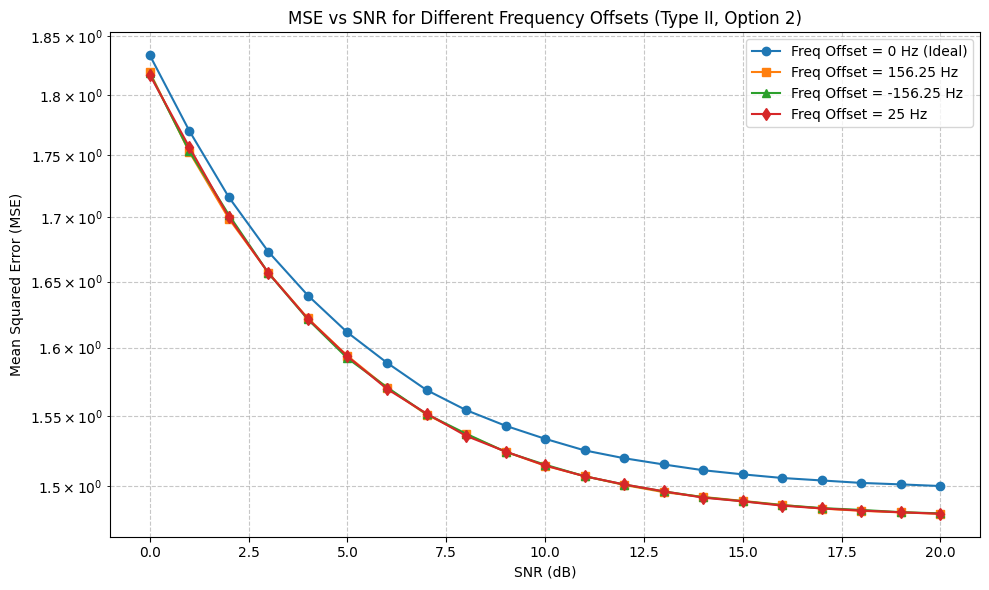

Done.


In [68]:
# Processing Functions
def process_chain_descrambled(x_down_scrambled, heq, feq, factor):
    """Processes a single sub-band after descrambling."""
    # Upsample
    y_up = np.zeros(len(x_down_scrambled) * factor, dtype=complex)
    y_up[::factor] = x_down_scrambled
    # Synthesis
    z = signal.convolve(y_up, feq, mode='full')
    # Scale correction
    return z * (1/factor)

def reconstruct_signal(rec_bands, option_num):
    rec_v0, rec_v1, rec_v2, rec_v3 = rec_bands
    # Process each sub-band through synthesis filters
    y0 = process_chain_descrambled(rec_v0.flatten(), Heq_V0, feqs[option_num-1][0], 8)
    y1 = process_chain_descrambled(rec_v1.flatten(), Heq_V1, feqs[option_num-1][1], 8)
    y2 = process_chain_descrambled(rec_v2.flatten(), Heq_V2, feqs[option_num-1][2], 4)
    y3 = process_chain_descrambled(rec_v3.flatten(), Heq_V3, feqs[option_num-1][3], 2)

    # Summing the signals
    max_len = np.max([len(y0), len(y1), len(y2), len(y3)])  
    total_out = np.zeros(max_len, dtype=complex)
    
    for y in [y0, y1, y2, y3]:
        total_out[:len(y)] += y
        
    return total_out

def calculate_mse(total_out, sig_type, system_gain, num_frames):
    x = load_signal(sig_type)
    x_full = np.tile(x, num_frames)
    
    # Normalize by system gain
    total_out_norm = total_out / system_gain
    
    # Truncate reconstruction to match original signal length
    x_hat = total_out_norm[:len(x_full)] 
    
    # Calculate Erro
    err = np.abs(x_full - x_hat)/np.abs(x_full)
    mse = np.sqrt(np.mean(err**2)) # RMS
    
    return mse

def apply_channel_effects(bands, snr_db, freq_offset_hz, fs=44100):
    """
    Applies Frequency Offset and AWGN to the sub-bands.
    
    Args:
        bands: List of sub-band arrays.
        snr_db: Signal-to-Noise Ratio in dB.
        freq_offset_hz: Frequency offset in Hz.
        fs: Sampling frequency (assumed 44100 Hz for audio context).
    """
    noisy_bands = []
    
    for b in bands:
        # Apply Frequency Offset
        # x(t) -> x(t) * e^(j * 2*pi * delta_f * t)
        t = np.arange(len(b)) / fs
        offset_phasor = np.exp(1j * 2 * np.pi * freq_offset_hz * t)
        b_shifted = b * offset_phasor
        
        # Add AWGN
        sig_power = np.mean(np.abs(b_shifted)**2)
        
        # Calculate noise power based on SNR
        # SNR_dB = 10 * log10(P_signal / P_noise)
        # P_noise = P_signal / 10^(SNR_dB / 10)
        noise_power = sig_power / (10**(snr_db / 10))
        
        # Generate complex Gaussian noise
        # Scale by sqrt(P_noise / 2) for real and imag parts
        noise_scale = np.sqrt(noise_power / 2)
        noise = noise_scale * (np.random.randn(len(b)) + 1j * np.random.randn(len(b)))
        
        noisy_bands.append(b_shifted + noise)
        
    return noisy_bands

# Calibrate Gains
print("Calculating System Gain For Normalization")
system_gains = {}
for opt in [1, 2]:
    gain, _, _, _, _ = calibrate_system_gain(opt)
    system_gains[opt] = gain

# Simulation Setup
N_FRAMES = 1000  # Reduced frames for faster plotting loop, increase to 1000 for high precision
configs = [('Type II', 2)] # Using Type II (Random), Option 2 for the requested Plot

# Initialize storage
raw_data_store = {key: [[], [], [], []] for key in configs}

print(f"\nGenerating base signal data ({N_FRAMES} frames)...")
for i in range(N_FRAMES):
    for sig_type, opt in configs:
        bands = load_process_signal_before_scrambling(sig_type, opt) #Load and process TX data
        for band_idx, band_data in enumerate(bands):
            raw_data_store[(sig_type, opt)][band_idx].append(band_data)

# Flatten bands for processing
target_key = ('Type II', 2)
band_lists = raw_data_store[target_key]
flat_bands = [np.concatenate(b_list) for b_list in band_lists]

# Scramble (Base scrambled signal to be transmitted)
print("Scrambling base signal...")
tx_scrambled_bands = scramble_signal_batch(*flat_bands, FRAMES, GROUP_ID)

# SNR and Offset Loop
snr_range = np.arange(0, 21, 1) # 0 to 20 dB
freq_offsets = [0, 2*78.125, -2*78.125, 25] # Hz
results_plot = {off: [] for off in freq_offsets}

print("\nRunning Simulation (MSE vs SNR)...")

for offset in freq_offsets:
    print(f"Processing Frequency Offset: {offset} Hz")
    mse_curve = []
    
    for snr in snr_range:
        # Apply Channel (Offset + Noise)
        rx_bands = apply_channel_effects(tx_scrambled_bands, snr, offset, fs=20000) # Note: FS=20000 is a placeholder
        
        # Descramble
        recovered_bands = descramble_signal_batch(*rx_bands, FRAMES, GROUP_ID)
        
        # Reconstruct
        total_output = reconstruct_signal(recovered_bands, 1)
        
        # Calculate MSE
        mse = calculate_mse(total_output, 'Type II', system_gains[1], N_FRAMES)
        mse_curve.append(mse)
        
    results_plot[offset] = mse_curve

# 4. Plotting
print("\nPlotting results...")
plt.figure(figsize=(10, 6))

markers = ['o', 's', '^', 'd']
for idx, offset in enumerate(freq_offsets):
    label_str = f"Freq Offset = {offset} Hz"
    if offset == 0: label_str += " (Ideal)"
    plt.plot(snr_range, results_plot[offset], marker=markers[idx], label=label_str)

plt.title('MSE vs SNR for Different Frequency Offsets (Type II, Option 2)')
plt.xlabel('SNR (dB)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.yscale('log') # MSE is often better viewed in Log scale
plt.tight_layout()
plt.show()

print("Done.")

#### Calculate Complexity of Operations

In [58]:
def calculate_complexity(n_fft):
    print("COMPUTATIONAL COMPLEXITY")
    print(f"(Per Frame per Stream, N_FFT = {n_fft})")
    
    # 4 LFSRs run for N_FFT cycles
    # Mapping formula: output = 1 - 2 * input_bit | We have 2 sequences (I and Q).
    # This mapping requires 1 Multiplication and 1 Addition per bit per sequence.
    pn_gen_mults = 2 * n_fft 
    pn_gen_adds = 2 * n_fft
    pn_gen_xor = (2 * n_fft) + (4 * n_fft)
    
    # Scrambling Application
    # Formula: V_out = Real(V)*PN_i + j * Imag(V)*PN_q
    # This involves element-wise multiplication of the Real part and Imag part.
    app_mults = 2 * n_fft
    app_adds = 0 # Constructing complex (a + jb) is structural
    
    total_mults = pn_gen_mults + app_mults
    total_adds = pn_gen_adds + app_adds
    
    print("1. PN Sequence Generation (on-the-fly):")
    print(f"   - Multiplications: {pn_gen_mults}")
    print(f"   - Additions:       {pn_gen_adds}")
    print(f"   - Bitwise XORs:    {pn_gen_xor}")
    print("-" * 30)
    print("2. Scrambling Application (Masking):")
    print(f"   - Multiplications: {app_mults}")
    print(f"   - Additions:       {app_adds}")
    print("-" * 30)
    print("TOTAL Arithmetic Ops (per frame, per stream):")
    print(f"   - Multiplications: {total_mults}")
    print(f"   - Additions:       {total_adds}")
    print("="*40)


# Calculate and show complexity
calculate_complexity(N_FFT)

COMPUTATIONAL COMPLEXITY
(Per Frame per Stream, N_FFT = 1024)
1. PN Sequence Generation (on-the-fly):
   - Multiplications: 2048
   - Additions:       2048
   - Bitwise XORs:    6144
------------------------------
2. Scrambling Application (Masking):
   - Multiplications: 2048
   - Additions:       0
------------------------------
TOTAL Arithmetic Ops (per frame, per stream):
   - Multiplications: 4096
   - Additions:       2048


# PART-III KALMAN FILTER

Running Kalman Filter on stock prices
Prediction RMSE: 4.1457


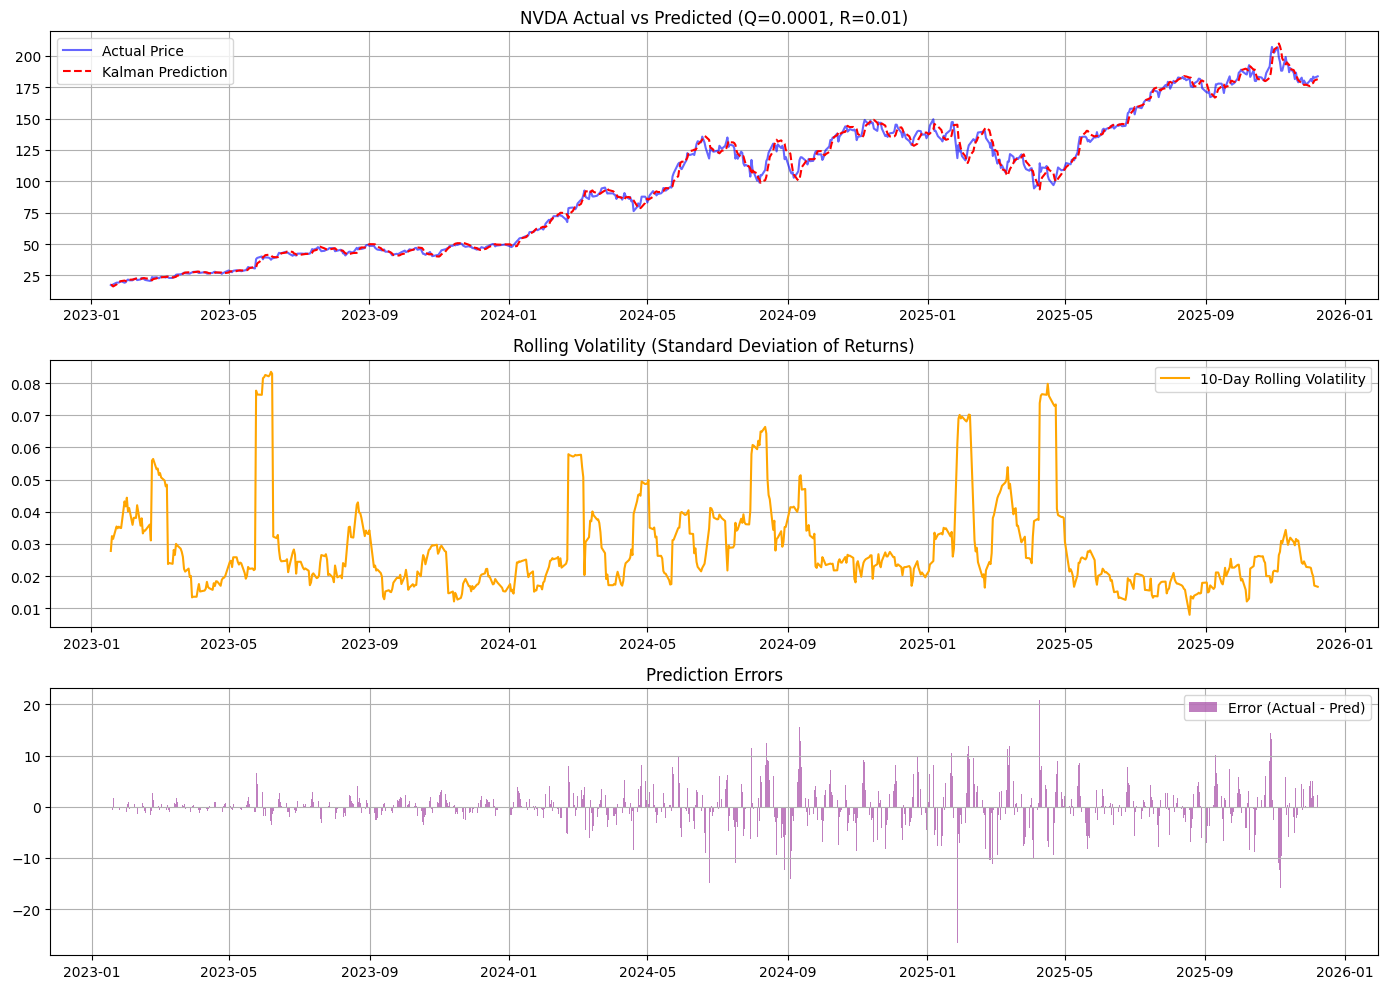

In [3]:
import yfinance as yf
import pandas as pd

# PARAMS
TICKER = 'NVDA'
START_DATE = '2023-01-01'
END_DATE = '2026-01-01'
ROLLING_WINDOW = 10

Q_PARAM = 0.0001 # 0.0001 # Q: Process Noise Covariance (Trust in the model)
R_PARAM = 0.01 # 0.01 # R: Observation Noise Covariance (Trust in the measurement)

def fetch_data(ticker, start, end):
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False)
    
    if data.empty:
        raise ValueError(f"No data downloaded for {ticker}. Check internet connection or symbol")
    
    if isinstance(data.columns, pd.MultiIndex):
        if ticker in data.columns.get_level_values(0):
            data = data.xs(ticker, axis=1, level=0) 
        elif ticker in data.columns.get_level_values(1):
            data = data.xs(ticker, axis=1, level=1)

    if 'Close' not in data.columns: # ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
        raise KeyError(f"'Close' column not found. Available columns: {data.columns}")
    
    return data[['Close']].copy()

def calculate_volatility(df, window):

    df['Returns'] = df['Close'].pct_change() # Daily Returns # pct_change() computes (current - previous) / previous    
    df['Rolling_Vol'] = df['Returns'].rolling(window=window).std() # Rolling Volatility (Standard Deviation of returns)
    df.dropna(inplace=True) # Fill NaN values created by the rolling window
    return df

class KalmanFilter:
    """
    Implement the Kalman Filter
    
    State Vector x: [Price, Velocity]
    State Transition Matrix F:
        P(t+1) = P(t) + V(t)
        V(t+1) = V(t)
    """
    def __init__(self, initial_price, Q_val, R_val):        
        self.x = np.array([[initial_price], [0]]) # Initial State Estimate [Price, Velocity]      
        self.P = np.eye(2) # State Covariance Matrix (P) - Uncertainty in our estimate
        
        # State Transition Matrix (F)
        # [[1, 1],
        #  [0, 1]]
        # This implies: Price_new = Price_old + Velocity
        self.F = np.array([[1, 1], [0, 1]])
        
        # Observation Matrix (H)
        # We only measure the Price, not the velocity directly
        self.H = np.array([[1, 0]])
        
        # Process Noise Covariance (Q)
        # We assume independent noise for price and velocity
        self.Q = np.eye(2) * Q_val
        
        # Measurement Noise Covariance (R)
        self.R = np.array([[R_val]])
        
    def predict(self):
        # 1. Extrapolate the state
        # x = F * x
        self.x = np.dot(self.F, self.x)
        
        # 2. Extrapolate uncertainty
        # P = F * P * F^T + Q
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x[0, 0] # Return predicted price

    def update(self, measurement):
        # y = z - H * x
        z = np.array([[measurement]])
        y = z - np.dot(self.H, self.x)

        # S = H * P * H^T + R
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        
        # K = P * H^T * S^-1 (Kalman Gain)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))

        # x = x + K * y
        self.x = self.x + np.dot(K, y)
        
        # P = (I - K * H) * P
        I = np.eye(self.F.shape[0])
        self.P = np.dot(I - np.dot(K, self.H), self.P)

try:
    df = fetch_data(TICKER, START_DATE, END_DATE)
    df = calculate_volatility(df, ROLLING_WINDOW)
except Exception as e:
    print(f"Error fetching data: {e}")

# Initialize KF
initial_price = df['Close'].iloc[0]
kf = KalmanFilter(initial_price, Q_PARAM, R_PARAM)

predictions = []
errors = []

print("Running Kalman Filter on stock prices")

for i in range(len(df)):
    current_actual_price = df['Close'].iloc[i]
    
    # Predict Step (Prior)
    pred_price = kf.predict()
    predictions.append(pred_price)
    
    # Update Step (Posterior) with actual observation
    kf.update(current_actual_price)
    
    # Calculate Error
    errors.append(current_actual_price - pred_price)
    
df['Predicted'] = predictions
df['Prediction_Error'] = errors

# Calculate RMSE
rmse = np.sqrt(np.mean(np.square(df['Prediction_Error'])))
print(f"Prediction RMSE: {rmse:.4f}")

# Plotting
plt.figure(figsize=(14, 10))

# Plot 1: Stock Price vs Prediction
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Close'], label='Actual Price', color='blue', alpha=0.6)
plt.plot(df.index, df['Predicted'], label='Kalman Prediction', color='red', linestyle='--')
plt.title(f'{TICKER} Actual vs Predicted (Q={Q_PARAM}, R={R_PARAM})')
plt.legend()
plt.grid(True)

# Plot 2: Rolling Volatility
plt.subplot(3, 1, 2)
plt.plot(df.index, df['Rolling_Vol'], color='orange', label=f'{ROLLING_WINDOW}-Day Rolling Volatility')
plt.title('Rolling Volatility (Standard Deviation of Returns)')
plt.legend()
plt.grid(True)

# Plot 3: Prediction Errors
plt.subplot(3, 1, 3)
plt.bar(df.index, df['Prediction_Error'], color='purple', alpha=0.5, label='Error (Actual - Pred)')
plt.title('Prediction Errors')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Experiment 1: Varying Q (Fixed R=0.01) ---
Q=1e-05: RMSE=3.5529, Accuracy=98.39%
Q=0.0001: RMSE=2.8810, Accuracy=98.71%
Q=0.001: RMSE=2.4792, Accuracy=98.87%

--- Experiment 2: Varying R (Fixed Q=0.0001) ---
R=0.001: RMSE=2.4795, Accuracy=98.87%
R=0.1: RMSE=3.5514, Accuracy=98.39%


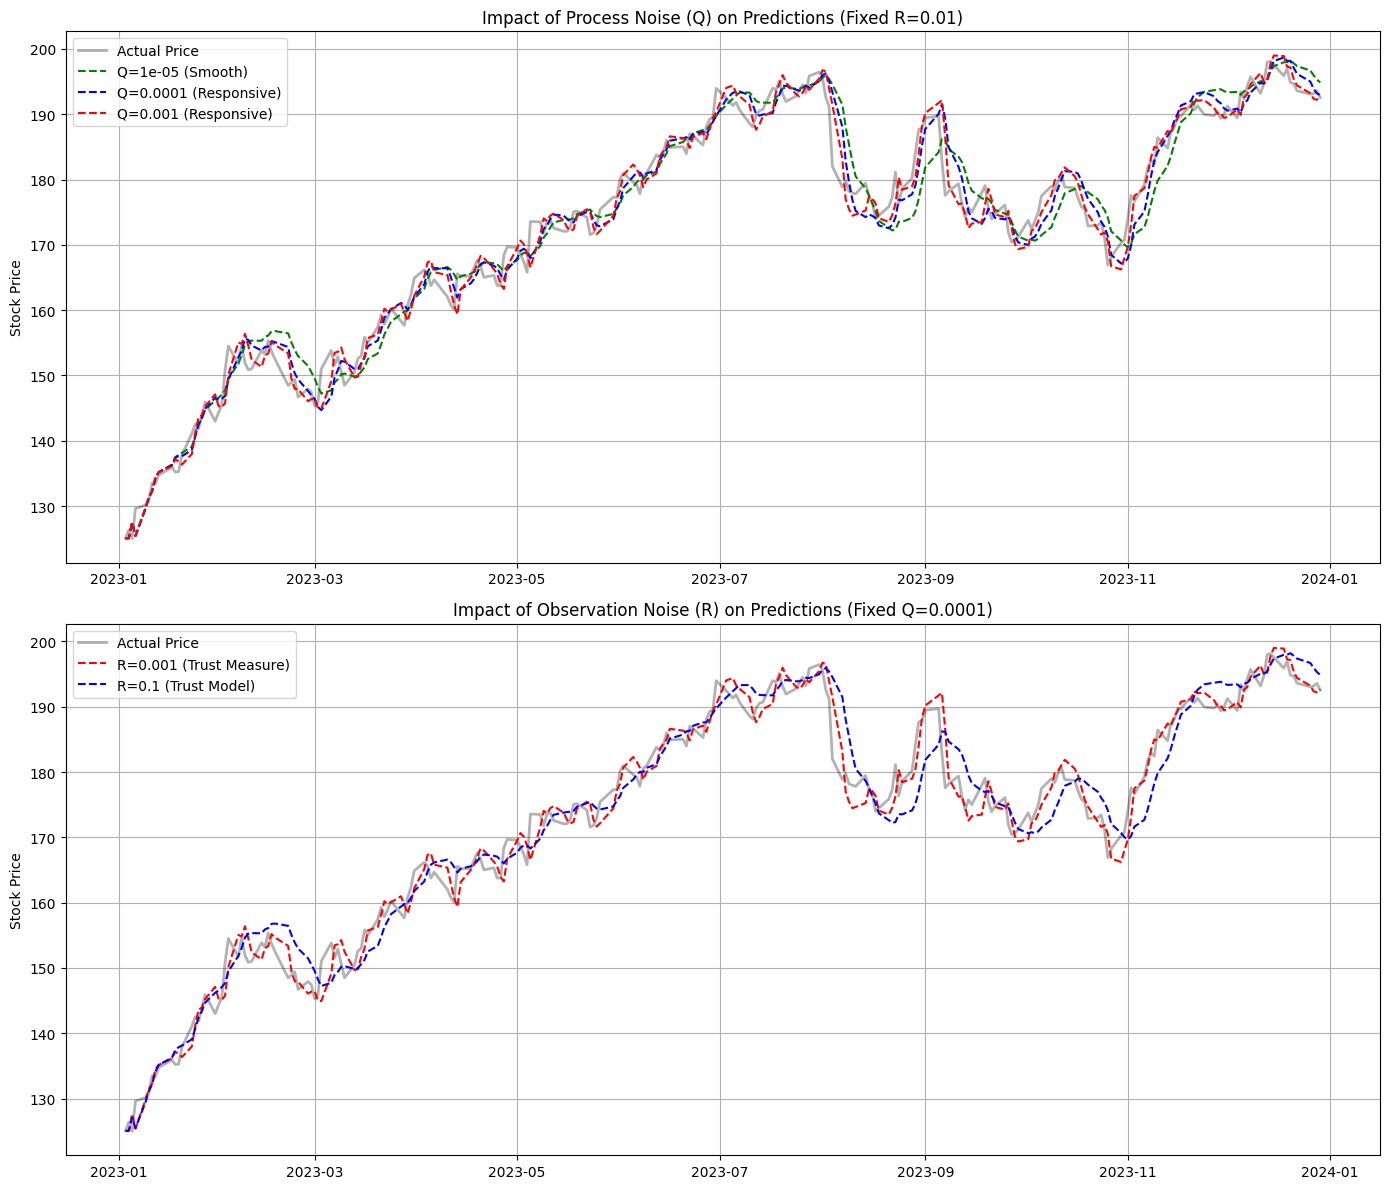

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TICKER = 'AAPL'
START_DATE = '2023-01-01'
END_DATE = '2024-01-01'
ROLLING_WINDOW = 10

# Experiment Sets
#  Varying Q (Process Noise) - Keeping R fixed at 0.01
Q_EXPERIMENTS = [0.00001, 0.0001, 0.001] 
R_FIXED_FOR_Q_EXP = 0.01

# Varying R (Measurement Noise) - Keeping Q fixed at 0.0001
R_EXPERIMENTS = [0.001, 0.1]
Q_FIXED_FOR_R_EXP = 0.0001

def fetch_data(ticker, start, end):
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False)
    
    if data.empty:
        raise ValueError(f"No data downloaded for {ticker}.")
    
    # Handle MultiIndex columns
    if isinstance(data.columns, pd.MultiIndex):
        if ticker in data.columns.get_level_values(0):
            data = data.xs(ticker, axis=1, level=0)
        elif ticker in data.columns.get_level_values(1):
            data = data.xs(ticker, axis=1, level=1)
            
    if 'Close' not in data.columns:
        raise KeyError("'Close' column not found.")
        
    return data[['Close']].copy()

class KalmanFilter:
    """Standard Kalman Filter Implementation"""
    def __init__(self, initial_price, Q_val, R_val):
        self.x = np.array([[initial_price], [0]]) # [Price, Velocity]
        self.P = np.eye(2) 
        self.F = np.array([[1, 1], [0, 1]]) # State Transition
        self.H = np.array([[1, 0]])         # Observation Matrix
        self.Q = np.eye(2) * Q_val          # Process Noise Cov
        self.R = np.array([[R_val]])        # Measurement Noise Cov
        
    def predict(self):
        self.x = np.dot(self.F, self.x)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x[0, 0]

    def update(self, measurement):
        z = np.array([[measurement]])
        y = z - np.dot(self.H, self.x)
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.F.shape[0])
        self.P = np.dot(I - np.dot(K, self.H), self.P)

def run_filter(df, q_val, r_val):
    """Helper function to run KF on the dataframe with specific Q and R"""
    initial_price = df['Close'].iloc[0]
    kf = KalmanFilter(initial_price, q_val, r_val)
    predictions = []
    
    for i in range(len(df)):
        current_actual = df['Close'].iloc[i]
        pred_price = kf.predict()
        predictions.append(pred_price)
        kf.update(current_actual)
        
    return predictions

def run_analysis():
    # Fetch Data
    try:
        df = fetch_data(TICKER, START_DATE, END_DATE)
    except Exception as e:
        print(f"Error: {e}")
        return

    # Create Plot Layout
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # VARYING Q (Process Noise)
    ax1.plot(df.index, df['Close'], label='Actual Price', color='black', alpha=0.3, linewidth=2)
    
    colors_q = ['green', 'blue', 'red']
    print(f"\n--- Experiment 1: Varying Q (Fixed R={R_FIXED_FOR_Q_EXP}) ---")
    
    for i, q_val in enumerate(Q_EXPERIMENTS):
        preds = run_filter(df, q_val, R_FIXED_FOR_Q_EXP)
        label = f'Q={q_val} ({"Smooth" if q_val < 0.0001 else "Responsive"})'
        ax1.plot(df.index, preds, label=label, color=colors_q[i], linestyle='--')
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean(np.square(df['Close'] - preds)))
        
        # Calculate Accuracy (100 - MAPE)
        # MAPE = Mean Absolute Percentage Error
        mape = np.mean(np.abs((df['Close'] - preds) / df['Close'])) * 100
        accuracy = 100 - mape
        
        print(f"Q={q_val}: RMSE={rmse:.4f}, Accuracy={accuracy:.2f}%")

    ax1.set_title(f'Impact of Process Noise (Q) on Predictions (Fixed R={R_FIXED_FOR_Q_EXP})')
    ax1.set_ylabel('Stock Price')
    ax1.legend()
    ax1.grid(True)

    # VARYING R (Measurement Noise)
    ax2.plot(df.index, df['Close'], label='Actual Price', color='black', alpha=0.3, linewidth=2)
    
    colors_r = ['red', 'blue']
    print(f"\n--- Experiment 2: Varying R (Fixed Q={Q_FIXED_FOR_R_EXP}) ---")
    
    for i, r_val in enumerate(R_EXPERIMENTS):
        preds = run_filter(df, Q_FIXED_FOR_R_EXP, r_val)
        label = f'R={r_val} ({"Trust Measure" if r_val < 0.01 else "Trust Model"})'
        ax2.plot(df.index, preds, label=label, color=colors_r[i], linestyle='--')
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean(np.square(df['Close'] - preds)))
        
        # Calculate Accuracy (100 - MAPE)
        mape = np.mean(np.abs((df['Close'] - preds) / df['Close'])) * 100
        accuracy = 100 - mape
        
        print(f"R={r_val}: RMSE={rmse:.4f}, Accuracy={accuracy:.2f}%")

    ax2.set_title(f'Impact of Observation Noise (R) on Predictions (Fixed Q={Q_FIXED_FOR_R_EXP})')
    ax2.set_ylabel('Stock Price')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_analysis()